In [1]:
import pickle

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from astropy.cosmology import WMAP9 as cosmo
from astropy.timeseries import LombScargle
import astropy.units as u

from tqdm.auto import tqdm
# from astropy import table as tbl

In [2]:
tqdm.pandas()

# Load/Create Catalogs

First we will load/create our quasar catalogs, including paths to lightcurve files for each one. For the CRTS sample we need to "make" this catalog manually, in the sense that we have to populate out light curve files (for now we only have two lightcurves, but hopefully later we will have more). We will also load a catalog spectroscopically confirmed QSOs with light curves in the SDSS DR7 stripe 82 (MacLeod+ 2011, http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html).

## CRTS Sample

In [3]:
with open('./data/crts_catalog.txt') as f:
    crts_catalog = pd.read_csv(f, sep='\s+', header=0)
    
crts_catalog['lightcurve'] = './data/lightcurves/CRTS/' + crts_catalog['dbId'].astype(str)
crts_catalog['fap'] = 1.
crts_catalog['f_orbit'] = 0
crts_catalog['f_gw'] = 2 * crts_catalog['f_orbit']
crts_catalog['t_obs'] = 0
crts_catalog

,Name,dbId,RA,Dec,Redshift,BH_mass,lightcurve,fap,f_orbit,f_gw,t_obs
0,UM234,2,5.763333,1.259417,0.729,9.19,./data/lightcurves/CRTS/2,1.0,0,0,0
1,SDSSJ014350.13+141453.0,3,25.958333,14.248583,1.438,9.21,./data/lightcurves/CRTS/3,1.0,0,0,0
2,US3204,6,42.370417,1.156944,0.954,8.95,./data/lightcurves/CRTS/6,1.0,0,0,0
3,RXSJ04117+1324,8,62.945417,13.404583,0.277,8.16,./data/lightcurves/CRTS/8,1.0,0,0,0
4,2MASSJ04352649-1643460,10,68.860417,-16.729361,0.098,7.78,./data/lightcurves/CRTS/10,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
93,SDSSJ170616.24+370927.0,102,256.567500,37.157500,1.267,9.10,./data/lightcurves/CRTS/102,1.0,0,0,0
94,FBQSJ17239+3748,104,260.976250,37.811583,0.828,9.38,./data/lightcurves/CRTS/104,1.0,0,0,0
95,SDSSJ172656.96+600348.5,105,261.737083,60.063639,0.991,9.15,./data/lightcurves/CRTS/105,1.0,0,0,0
96,SDSSJ221016.97+122213.9,108,332.570833,12.370556,0.717,9.00,./data/lightcurves/CRTS/108,1.0,0,0,0


## SDSS DR7 Stripe 82

First we'll load the stripe 82 sample. It doesn't really matter what order we load our catalogs in, and (asssuming we get more CRTS data) we'll use the CRTS catalog to calibrate. However we'd like the CRTS catalog format to match the SDSS catalog format, so we'll load the SDSS catalog first so we can use it as a reference.

In [4]:
with open('./data/sdss_catalog.txt') as f:
    sdss_catalog = pd.read_csv(f, sep='\s+', header=0)
    
sdss_catalog['lightcurve'] = './data/lightcurves/SDSS/' + sdss_catalog['dbId'].astype(str)
sdss_catalog['fap'] = 1.
sdss_catalog['f_orbit'] = 0
sdss_catalog['f_gw'] = 2 * sdss_catalog['f_orbit']
sdss_catalog['t_obs'] = 0
sdss_catalog

,Name,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs
0,000840.63+011419.1,70,2.16931,1.23865,1.0737,7.52,1.52,./data/lightcurves/SDSS/70,1.0,0,0,0
1,000421.84+005743.6,98,1.09103,0.96212,0.7929,8.82,0.17,./data/lightcurves/SDSS/98,1.0,0,0,0
2,000119.50+001038.0,233,0.33129,0.17723,1.6209,8.92,0.20,./data/lightcurves/SDSS/233,1.0,0,0,0
3,000527.52-000556.2,1018,1.36470,-0.09896,0.6124,9.02,0.27,./data/lightcurves/SDSS/1018,1.0,0,0,0
4,000053.17-001732.9,1310,0.22156,-0.29249,2.7571,9.25,0.06,./data/lightcurves/SDSS/1310,1.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9249,022346.50+011526.7,2004174,35.94376,1.25743,2.4168,8.26,0.17,./data/lightcurves/SDSS/2004174,1.0,0,0,0
9250,022350.32+011433.2,2020108,35.95967,1.24256,1.8007,8.45,0.51,./data/lightcurves/SDSS/2020108,1.0,0,0,0
9251,025610.91+011324.3,2474692,44.04546,1.22344,0.9871,8.02,0.33,./data/lightcurves/SDSS/2474692,1.0,0,0,0
9252,034127.35+011514.2,4952501,55.36400,1.25396,3.1043,9.18,0.20,./data/lightcurves/SDSS/4952501,1.0,0,0,0


# Initial data exploration

Here we take an initial look at the light curves for the quasars we're exploring.

In [5]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
context = 'talk'
sns.set_context(context)
sns.set_style('ticks')
sns.set_palette('colorblind')
rcparams = {'font.family': 'DejaVu Sans',
            'font.serif': 'Times',
            'lines.markersize': np.sqrt(10),
            'text.latex.preamble': r'\\usepackage{amsmath}',
            'text.usetex': False,
            # 'hatch.linewidth' : 3.0,
            'figure.figsize': (12.8, 9.6),
            'xtick.direction': 'in',
            'xtick.top': True,
            'xtick.minor.visible': True,
            'ytick.minor.visible': True,
            'ytick.right': True,
            'ytick.direction': 'in'}
plt.rcParams.update(rcparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
def plot_lightcurve(catalog, n_cols=2, n_stds=3, model=False, filename=None, band=None):
    n_plots = len(catalog)

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols
    
    if band is not None:
        mjd_tag = f'MJD_{band}'
        mag_tag = f'{band}'
        magerr_tag = f'{band}_err'
        
        lc_cols = ['MJD_u', 'u', 'u_err',
                   'MJD_g', 'g', 'g_err',
                   'MJD_r', 'r', 'r_err',
                   'MJD_i', 'i', 'i_err',
                   'MJD_z', 'z', 'z_err',
                   'ra_median', 'decl_median']
    else:
        mjd_tag = 'MJD'
        mag_tag = 'Mag'
        magerr_tag = 'Magerr'
        
        lc_cols = ['Mag', 'Magerr', 'MJD']

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(6.4 * 4, 9.6 / 2 * n_rows))

    for i, a in enumerate(ax.flatten()):
        filepath = catalog['lightcurve'].iloc[i]
        
        if band is not None:
            with open(filepath) as f:
                lc = pd.read_csv(f, names=lc_cols, sep='\s+')
        else:
            with open(filepath) as f:
                lc = pd.read_csv(f, names=lc_cols, sep=',', header=0)
            
        lc = lc[lc[mag_tag] >= 0]  # remove contaminated data points because there are no quasars that bright
        
        a.errorbar(lc[mjd_tag], lc[mag_tag], yerr=lc[magerr_tag],
                    marker='o', linestyle='none')
        
        med = np.median(lc[mag_tag])
        std = np.std(lc[mag_tag])
        ylow = med - n_stds * std
        yhigh = med + n_stds * std
        
        if model:
            mjd = (lc[mjd_tag].values * u.day).to(u.s)  # convert MJD to sec
            mag = lc[mag_tag].values * u.mag  # for now we'll only search over visual magnitudes
            magerr = lc[magerr_tag].values * u.mag
        
            ls = LombScargle(mjd, mag, magerr)

            frequency, power = ls.autopower(samples_per_peak=100)

            best_frequency = frequency[np.argmax(power)]
            t_fit = np.linspace(mjd.min(), mjd.max(), num=1000)
            y_fit = ls.model(t_fit, best_frequency)

            a.plot(t_fit.to(u.day), y_fit)

        a.set_ylim(ylow, yhigh)

        a.set_xlabel('MJD')
        a.set_ylabel('Mag')
        a.set_title(catalog['Name'].iloc[i])

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(f'./figures/{filename}.pdf')
        plt.savefig(f'./figures/{filename}.png')
        
    plt.show()

## Plot CRTS light curves

First we'll plot the first 10 CRTS light curves.

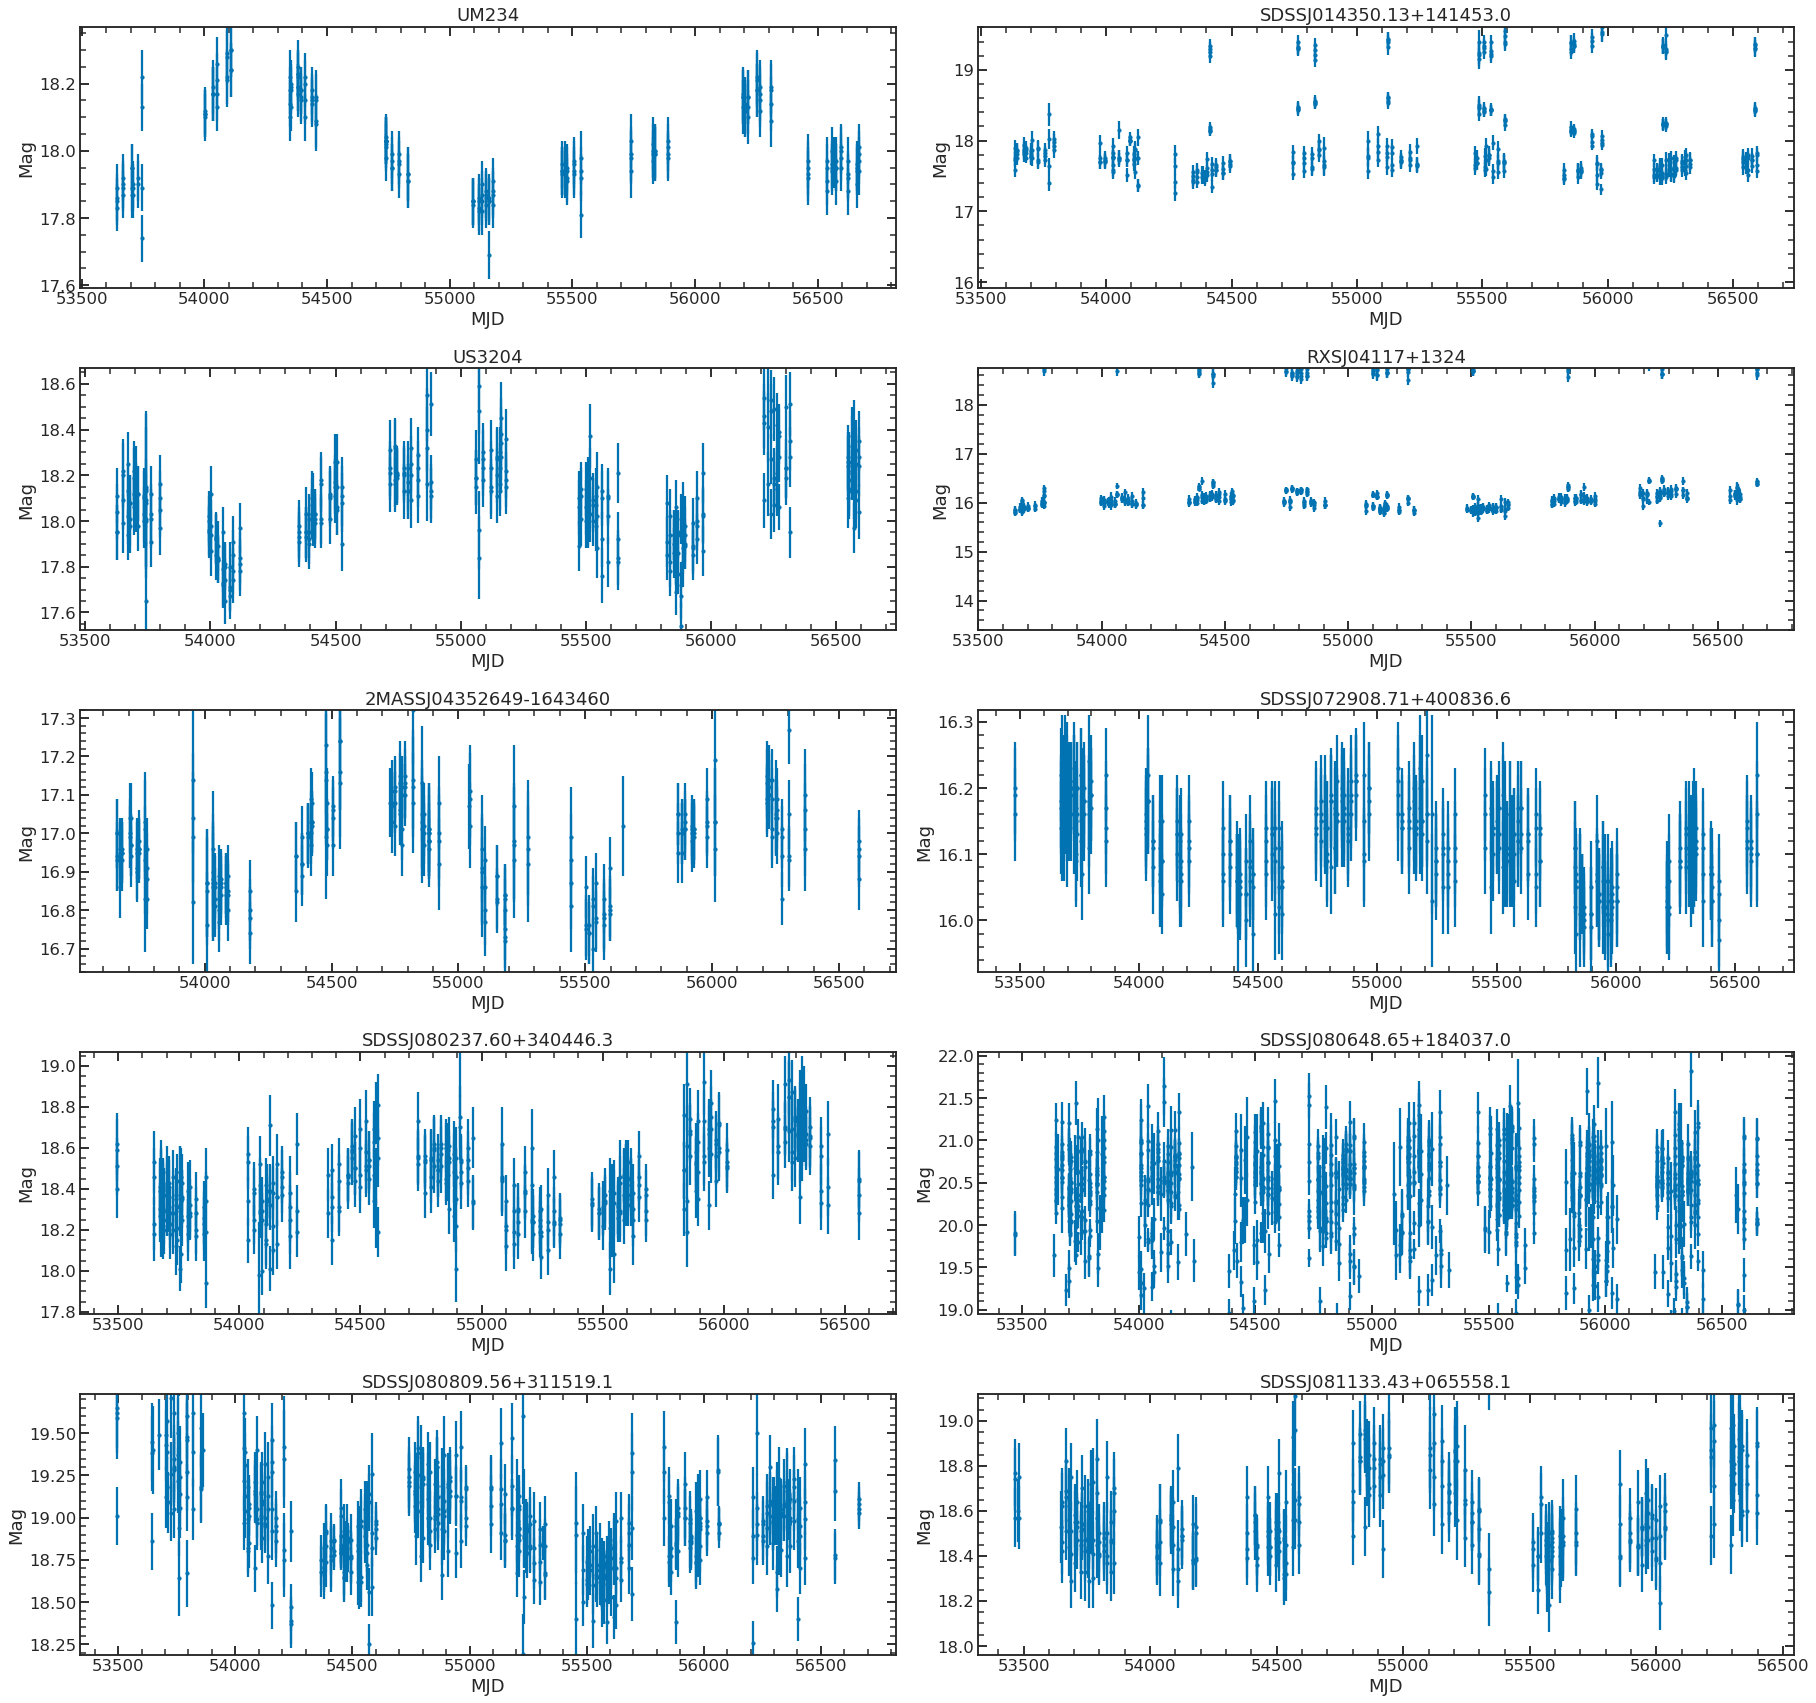

In [7]:
plot_lightcurve(crts_catalog[:10], filename='crts_lightcurves')

## Plot SDSS light curves

First we'll plot some random SDSS light curves.

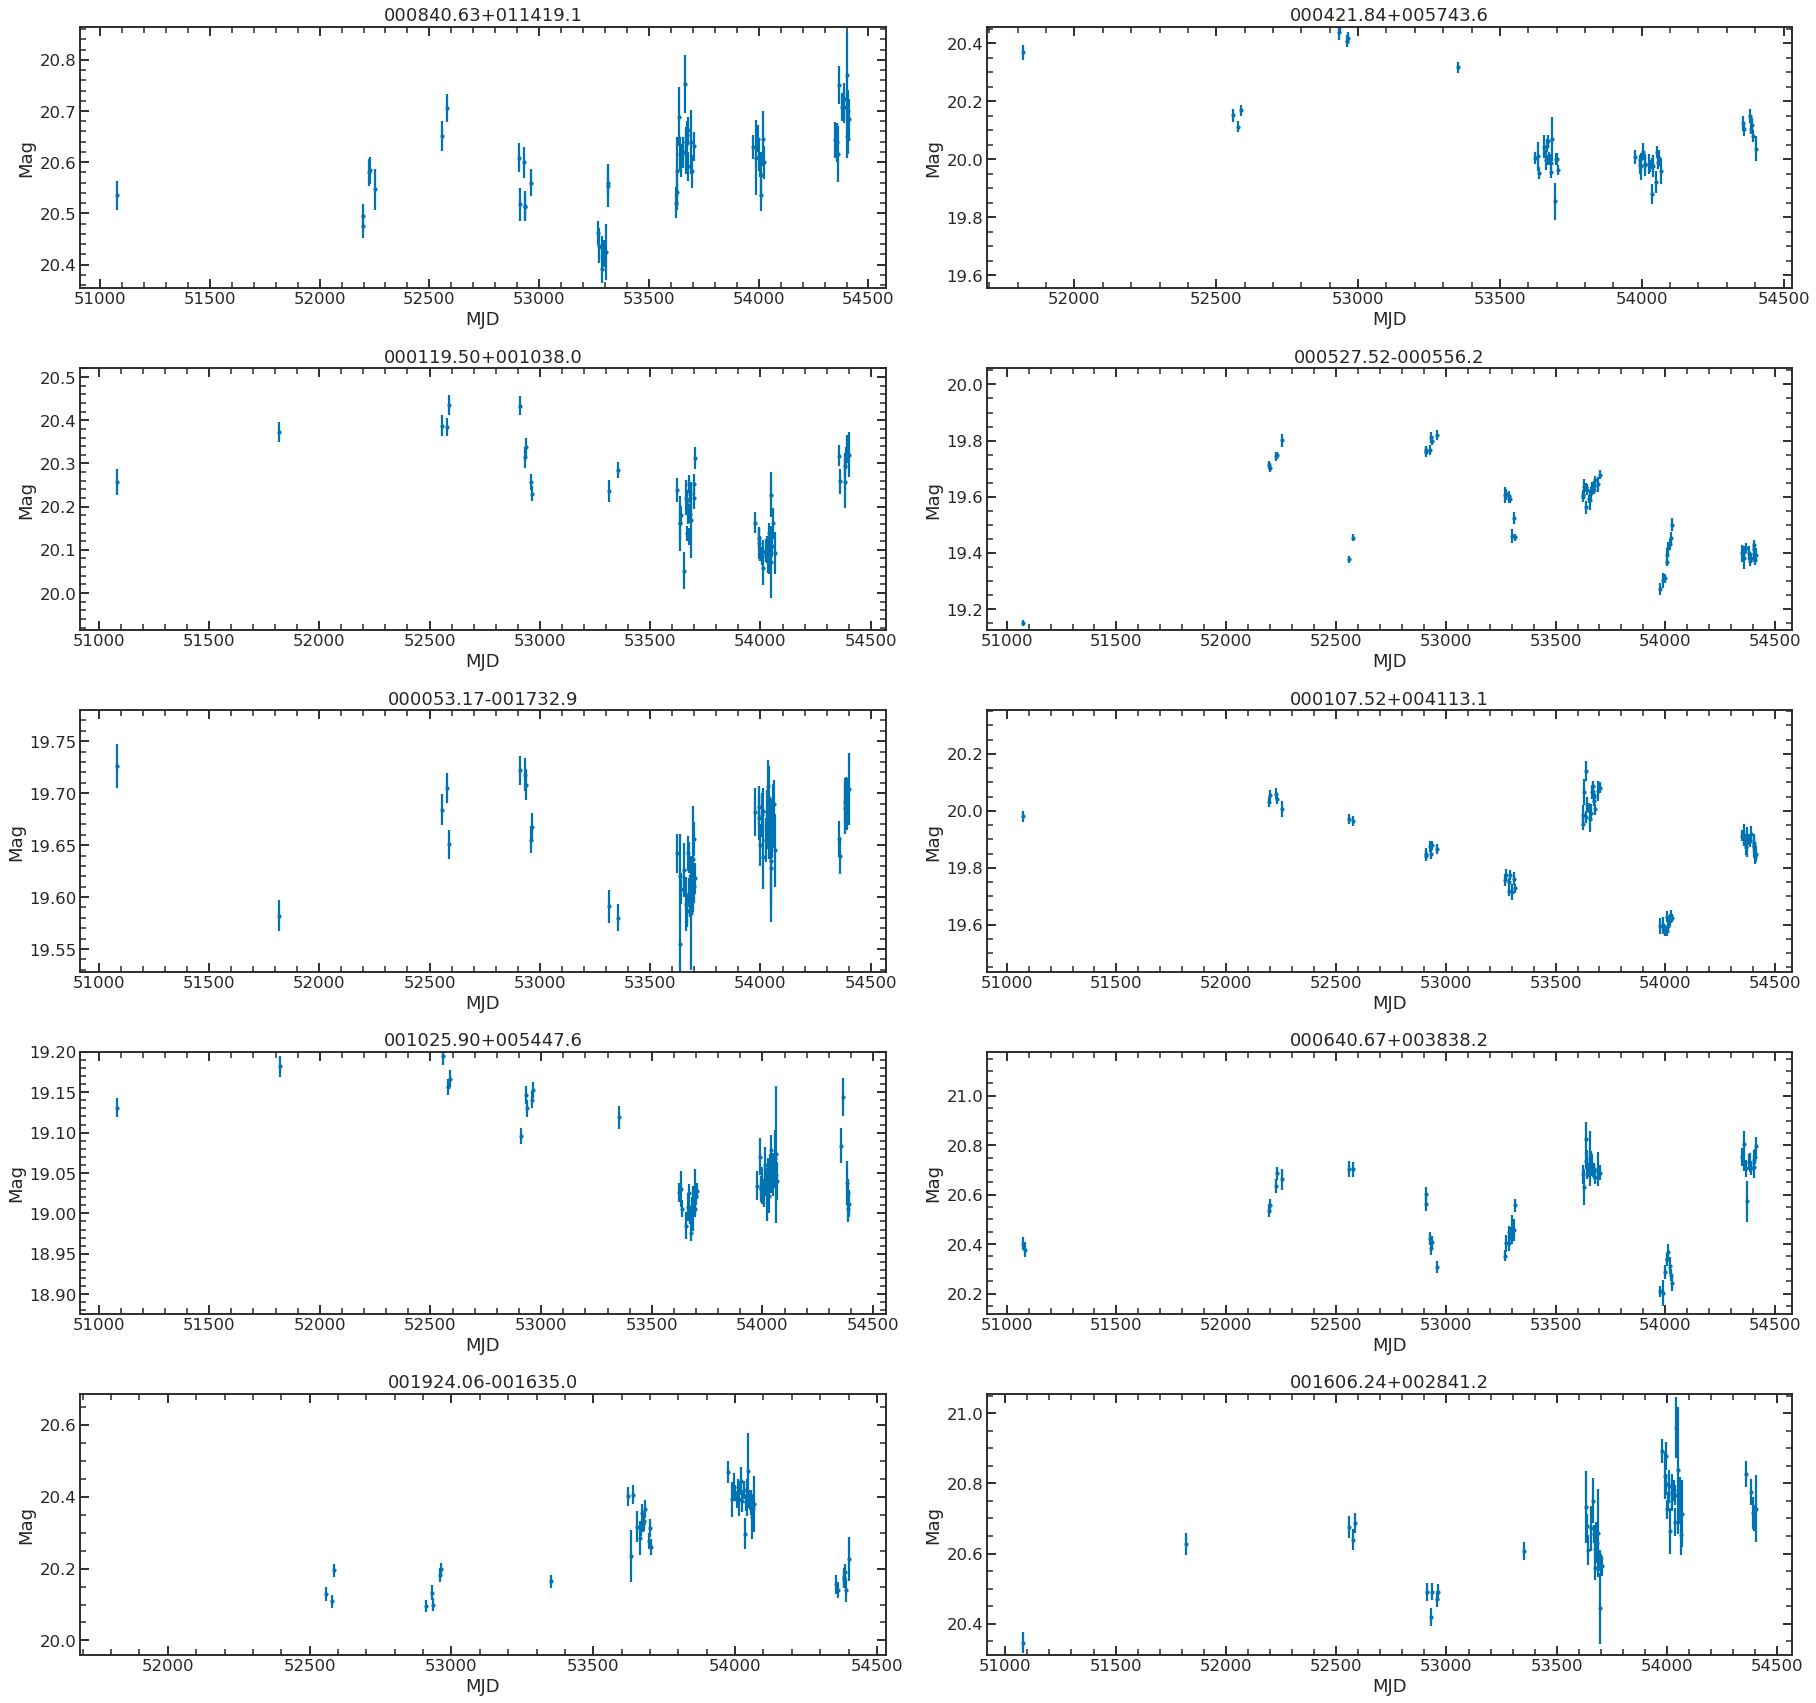

In [8]:
plot_lightcurve(sdss_catalog[:10], n_stds=3, filename='sdss_lightcurves', band='g')

# Lomb-Scargle

First we'll use Lomb-Scargle to explore our data. This will give us a good idea of what the power spectral density of the light curves are. This also will give us a starting point for the MCMC parameter fitting we'll do later.

In [9]:
def plot_lomb_scargle_psd(catalog, n_cols=2, filename=None, band=None):
    n_plots = len(catalog)

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols
    
    if band is not None:
        mjd_tag = f'MJD_{band}'
        mag_tag = f'{band}'
        magerr_tag = f'{band}_err'
        
        lc_cols = ['MJD_u', 'u', 'u_err',
                   'MJD_g', 'g', 'g_err',
                   'MJD_r', 'r', 'r_err',
                   'MJD_i', 'i', 'i_err',
                   'MJD_z', 'z', 'z_err',
                   'ra_median', 'decl_median']
    else:
        mjd_tag = 'MJD'
        mag_tag = 'Mag'
        magerr_tag = 'Magerr'
        
        lc_cols = ['Mag', 'Magerr', 'MJD']

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(6.4 * 4, 9.6 / 2 * n_rows))

    for i, a in enumerate(ax.flatten()):
        filepath = catalog['lightcurve'].iloc[i]
        
        if band is not None:
            with open(filepath) as f:
                lc = pd.read_csv(f, names=lc_cols, sep='\s+')
        else:
            with open(filepath) as f:
                lc = pd.read_csv(f, names=lc_cols, sep=',', header=0)
            
        lc = lc[lc[mag_tag] >= 0]  # remove contaminated data points because there are no quasars that bright
        
        mjd = (lc[mjd_tag].values * u.day).to(u.s)  # convert MJD to sec
        mag = lc[mag_tag].values * u.mag  # for now we'll only search over visual magnitudes
        magerr = lc[magerr_tag].values * u.mag

        ls = LombScargle(mjd, mag, magerr)

        frequency, power = ls.autopower(samples_per_peak=100)

        a.plot(frequency, power)
        a.set_xscale('log')

        a.set_xlabel('$f~[\\rm{Hz}]$')
        a.set_ylabel('Lomb-Scargle Power')
        a.set_title(catalog['Name'].iloc[i])

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(f'./figures/{filename}.pdf')
        plt.savefig(f'./figures/{filename}.png')
        
    plt.show()

## CRTS Periodograms

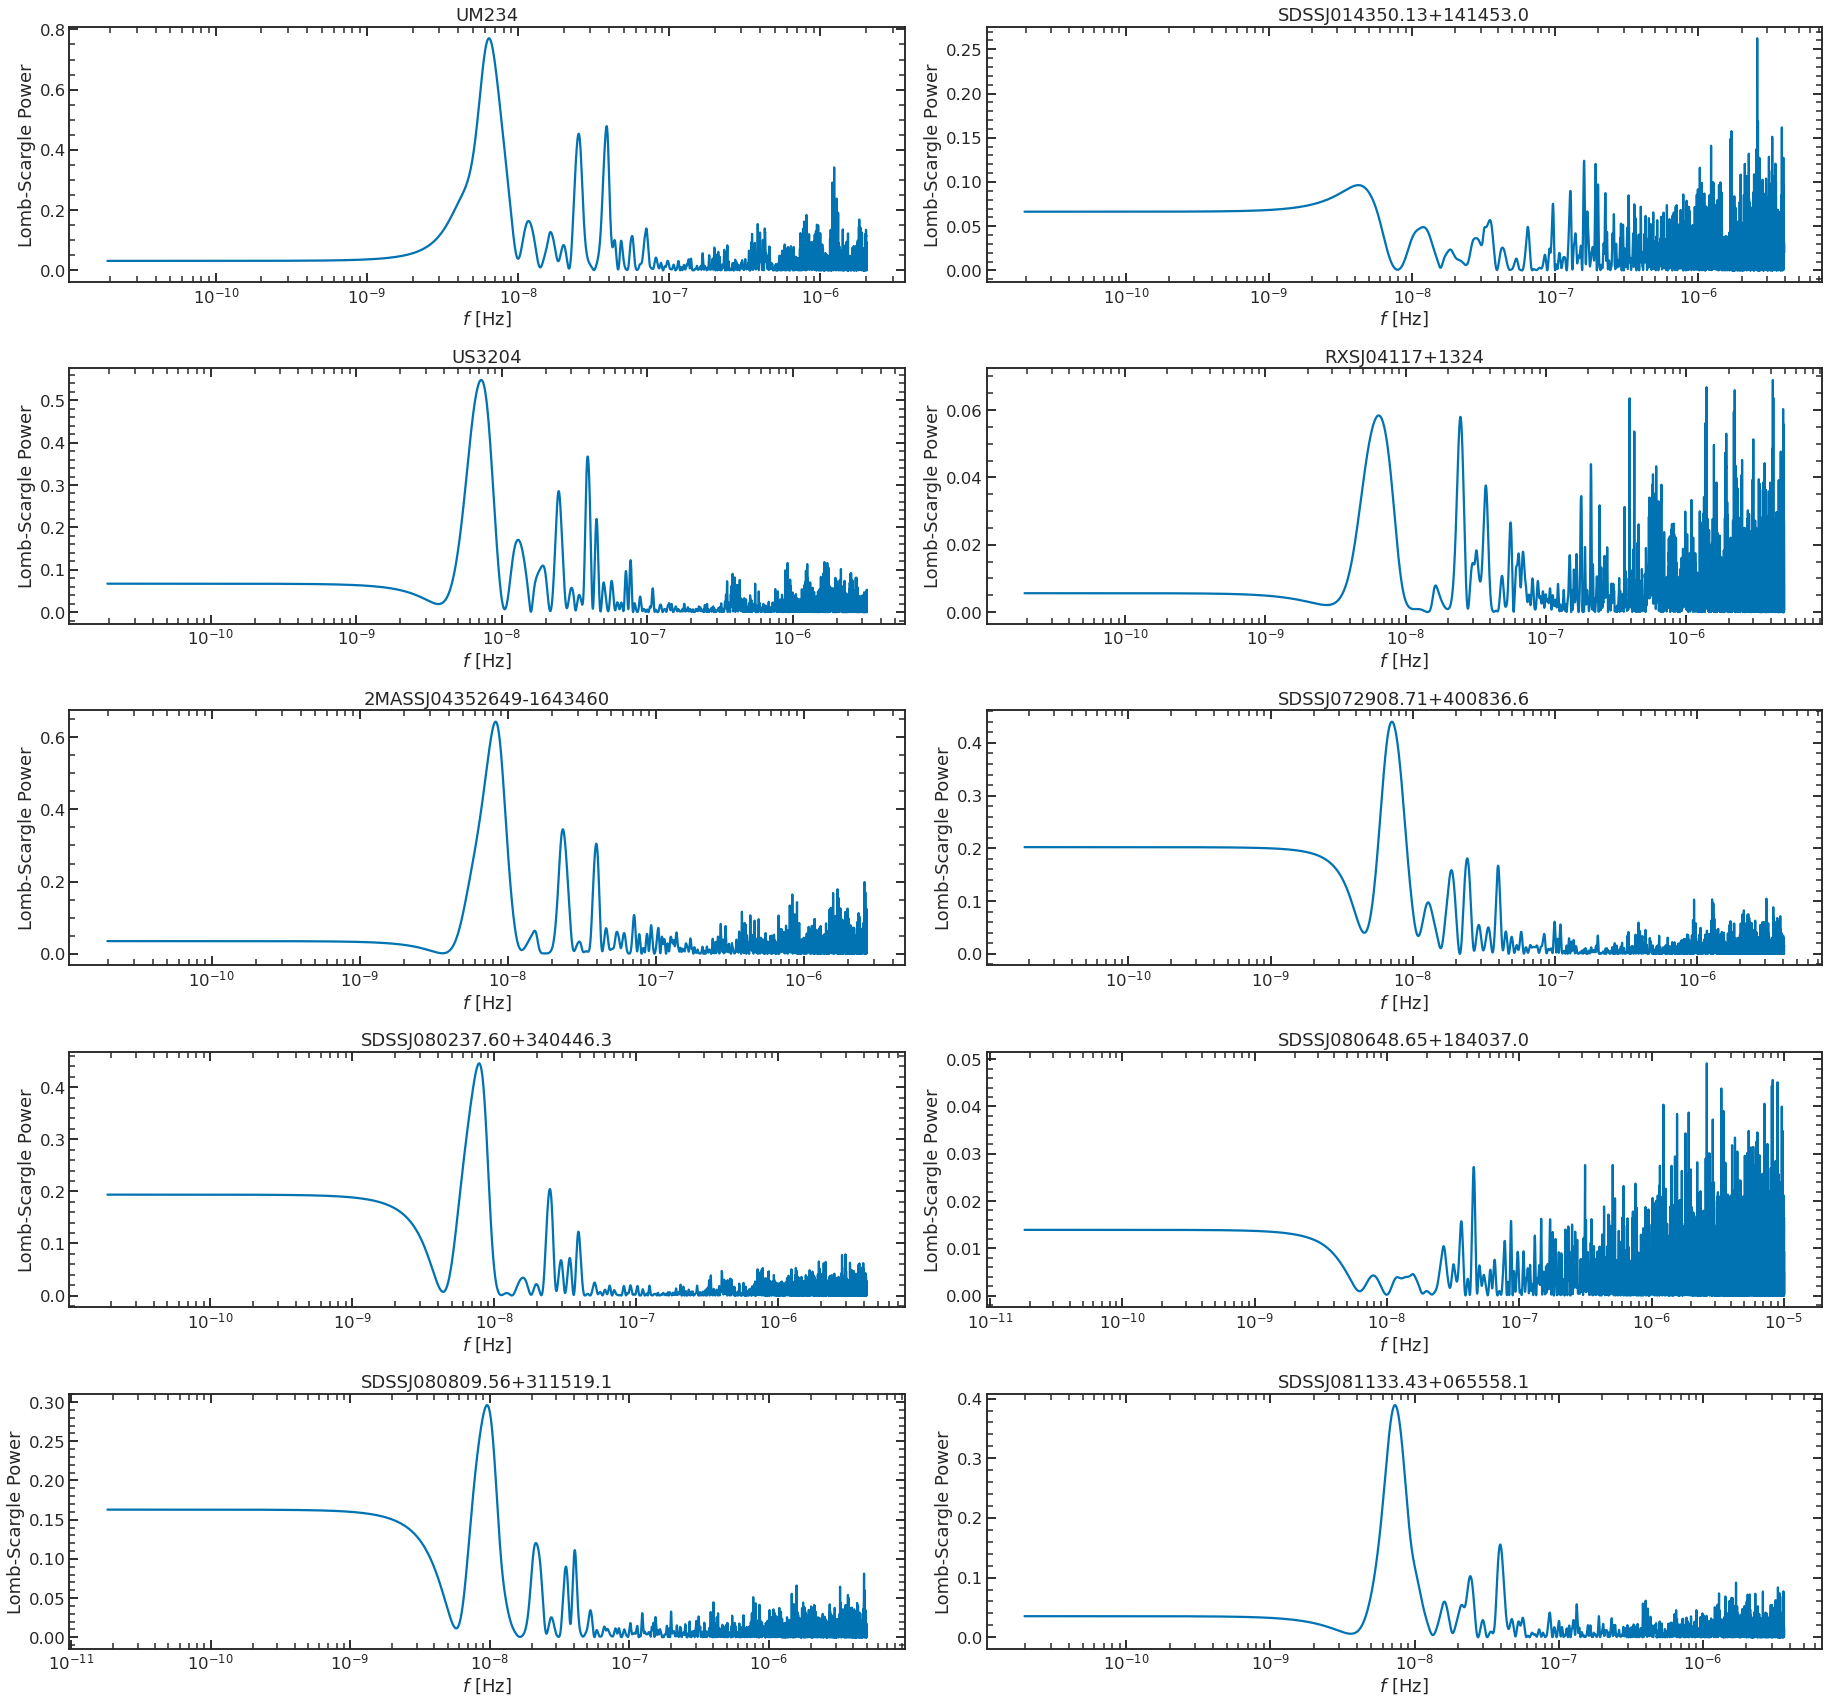

In [10]:
plot_lomb_scargle_psd(crts_catalog[:10], n_cols=2, filename='crts_periodograms')

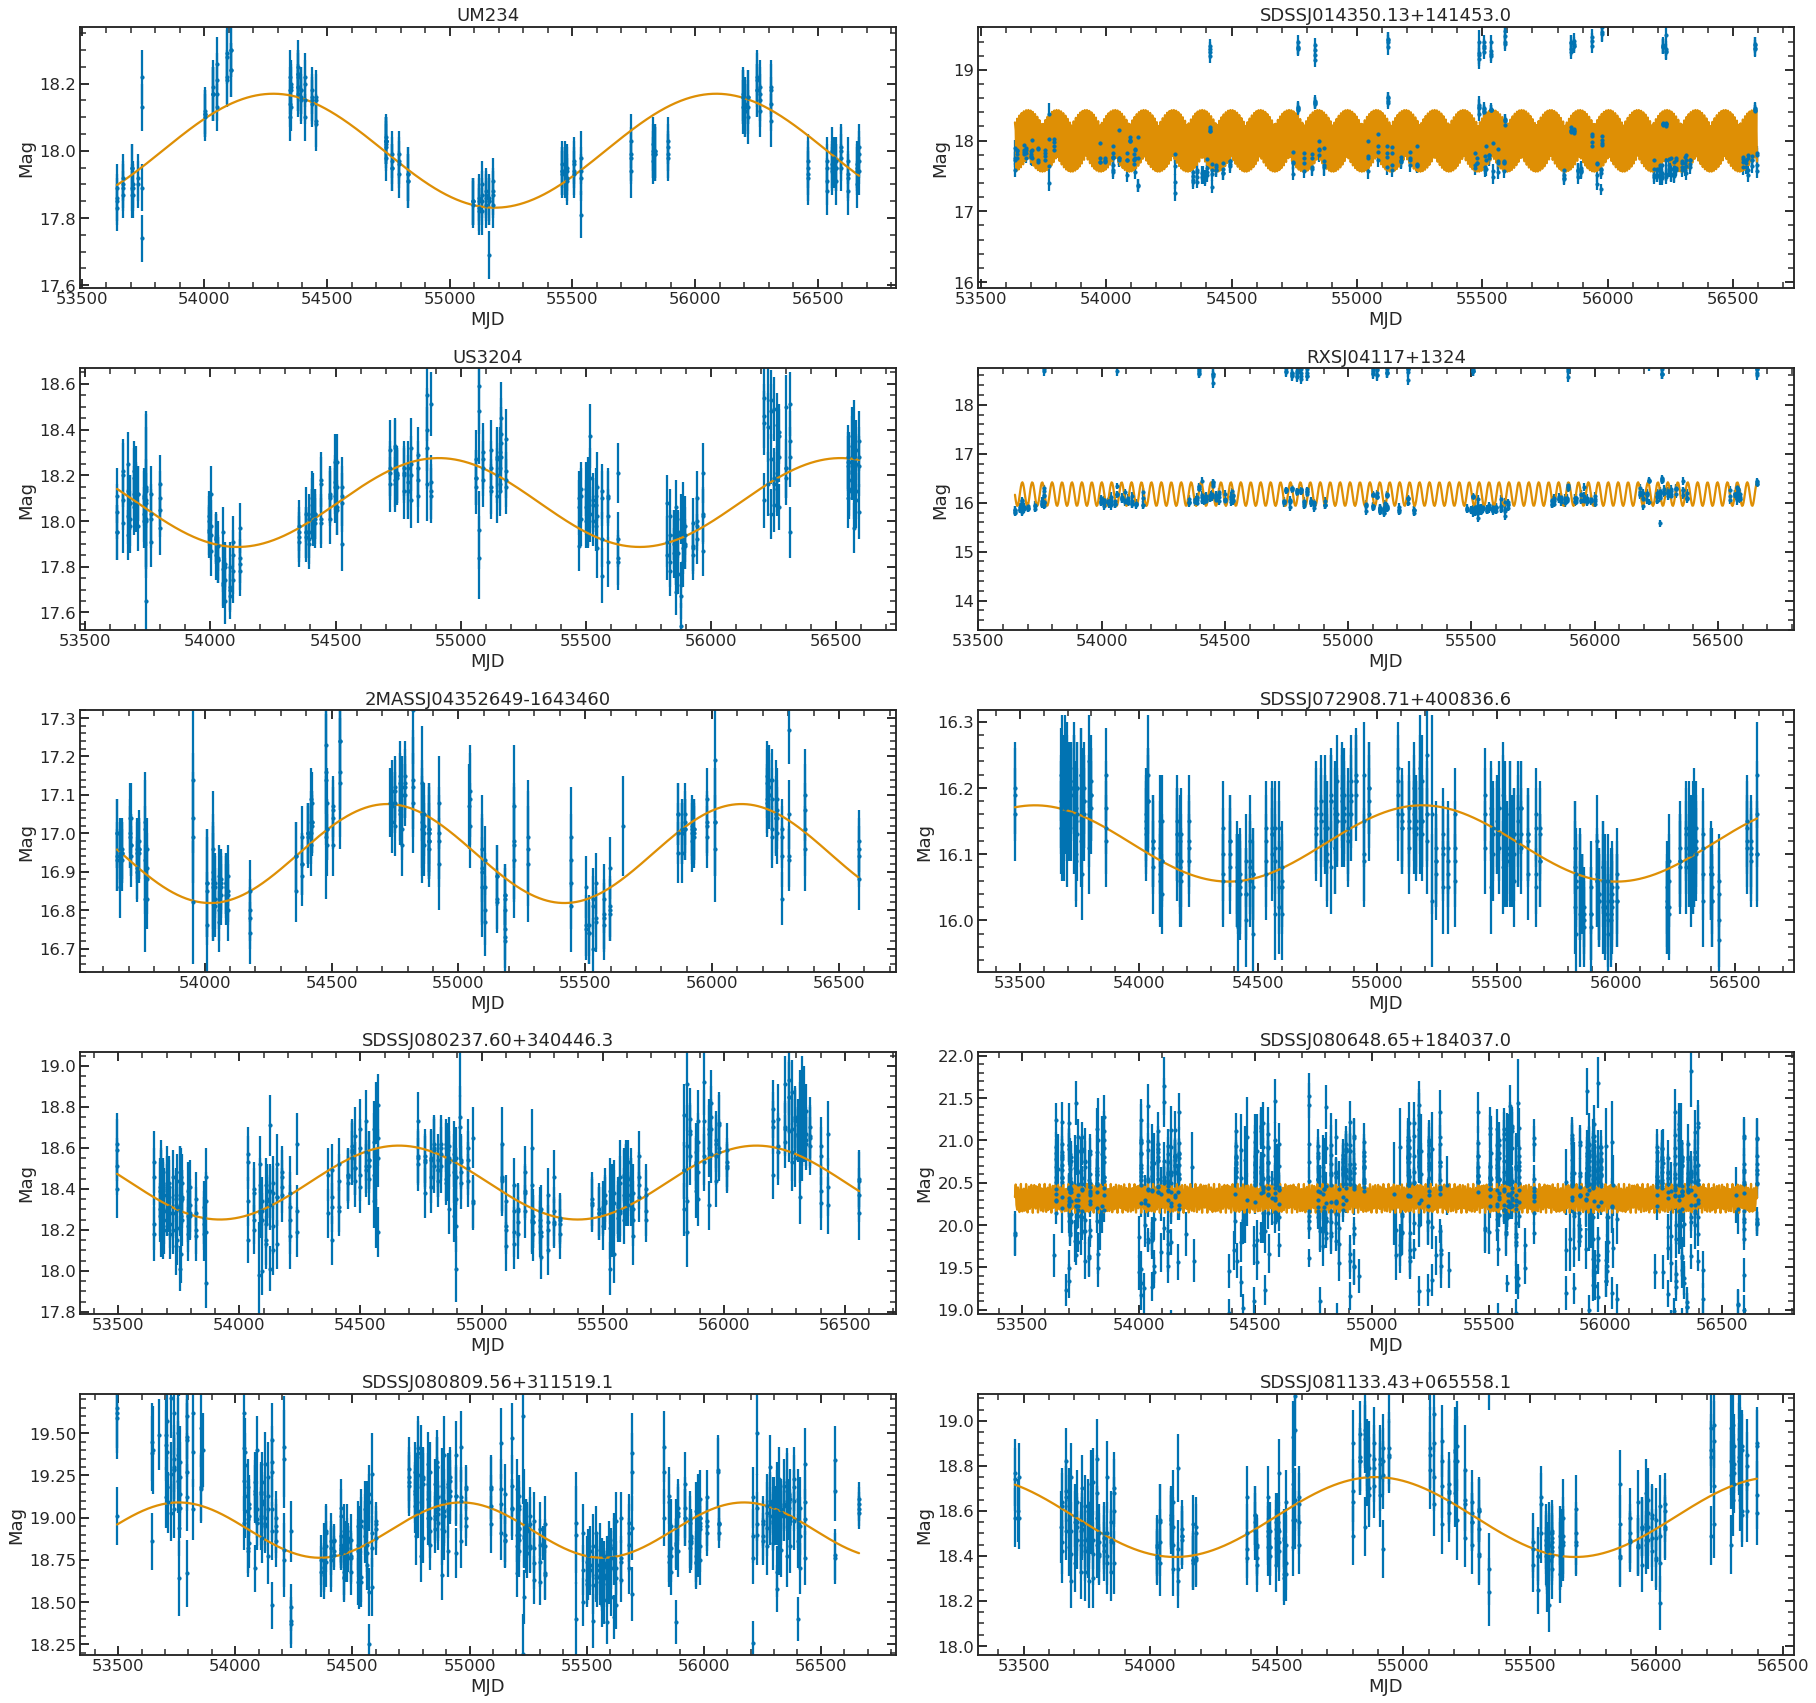

In [11]:
plot_lightcurve(crts_catalog[:10], model=True, filename='crts_lightcurves_model')

## SDSS Periodograms

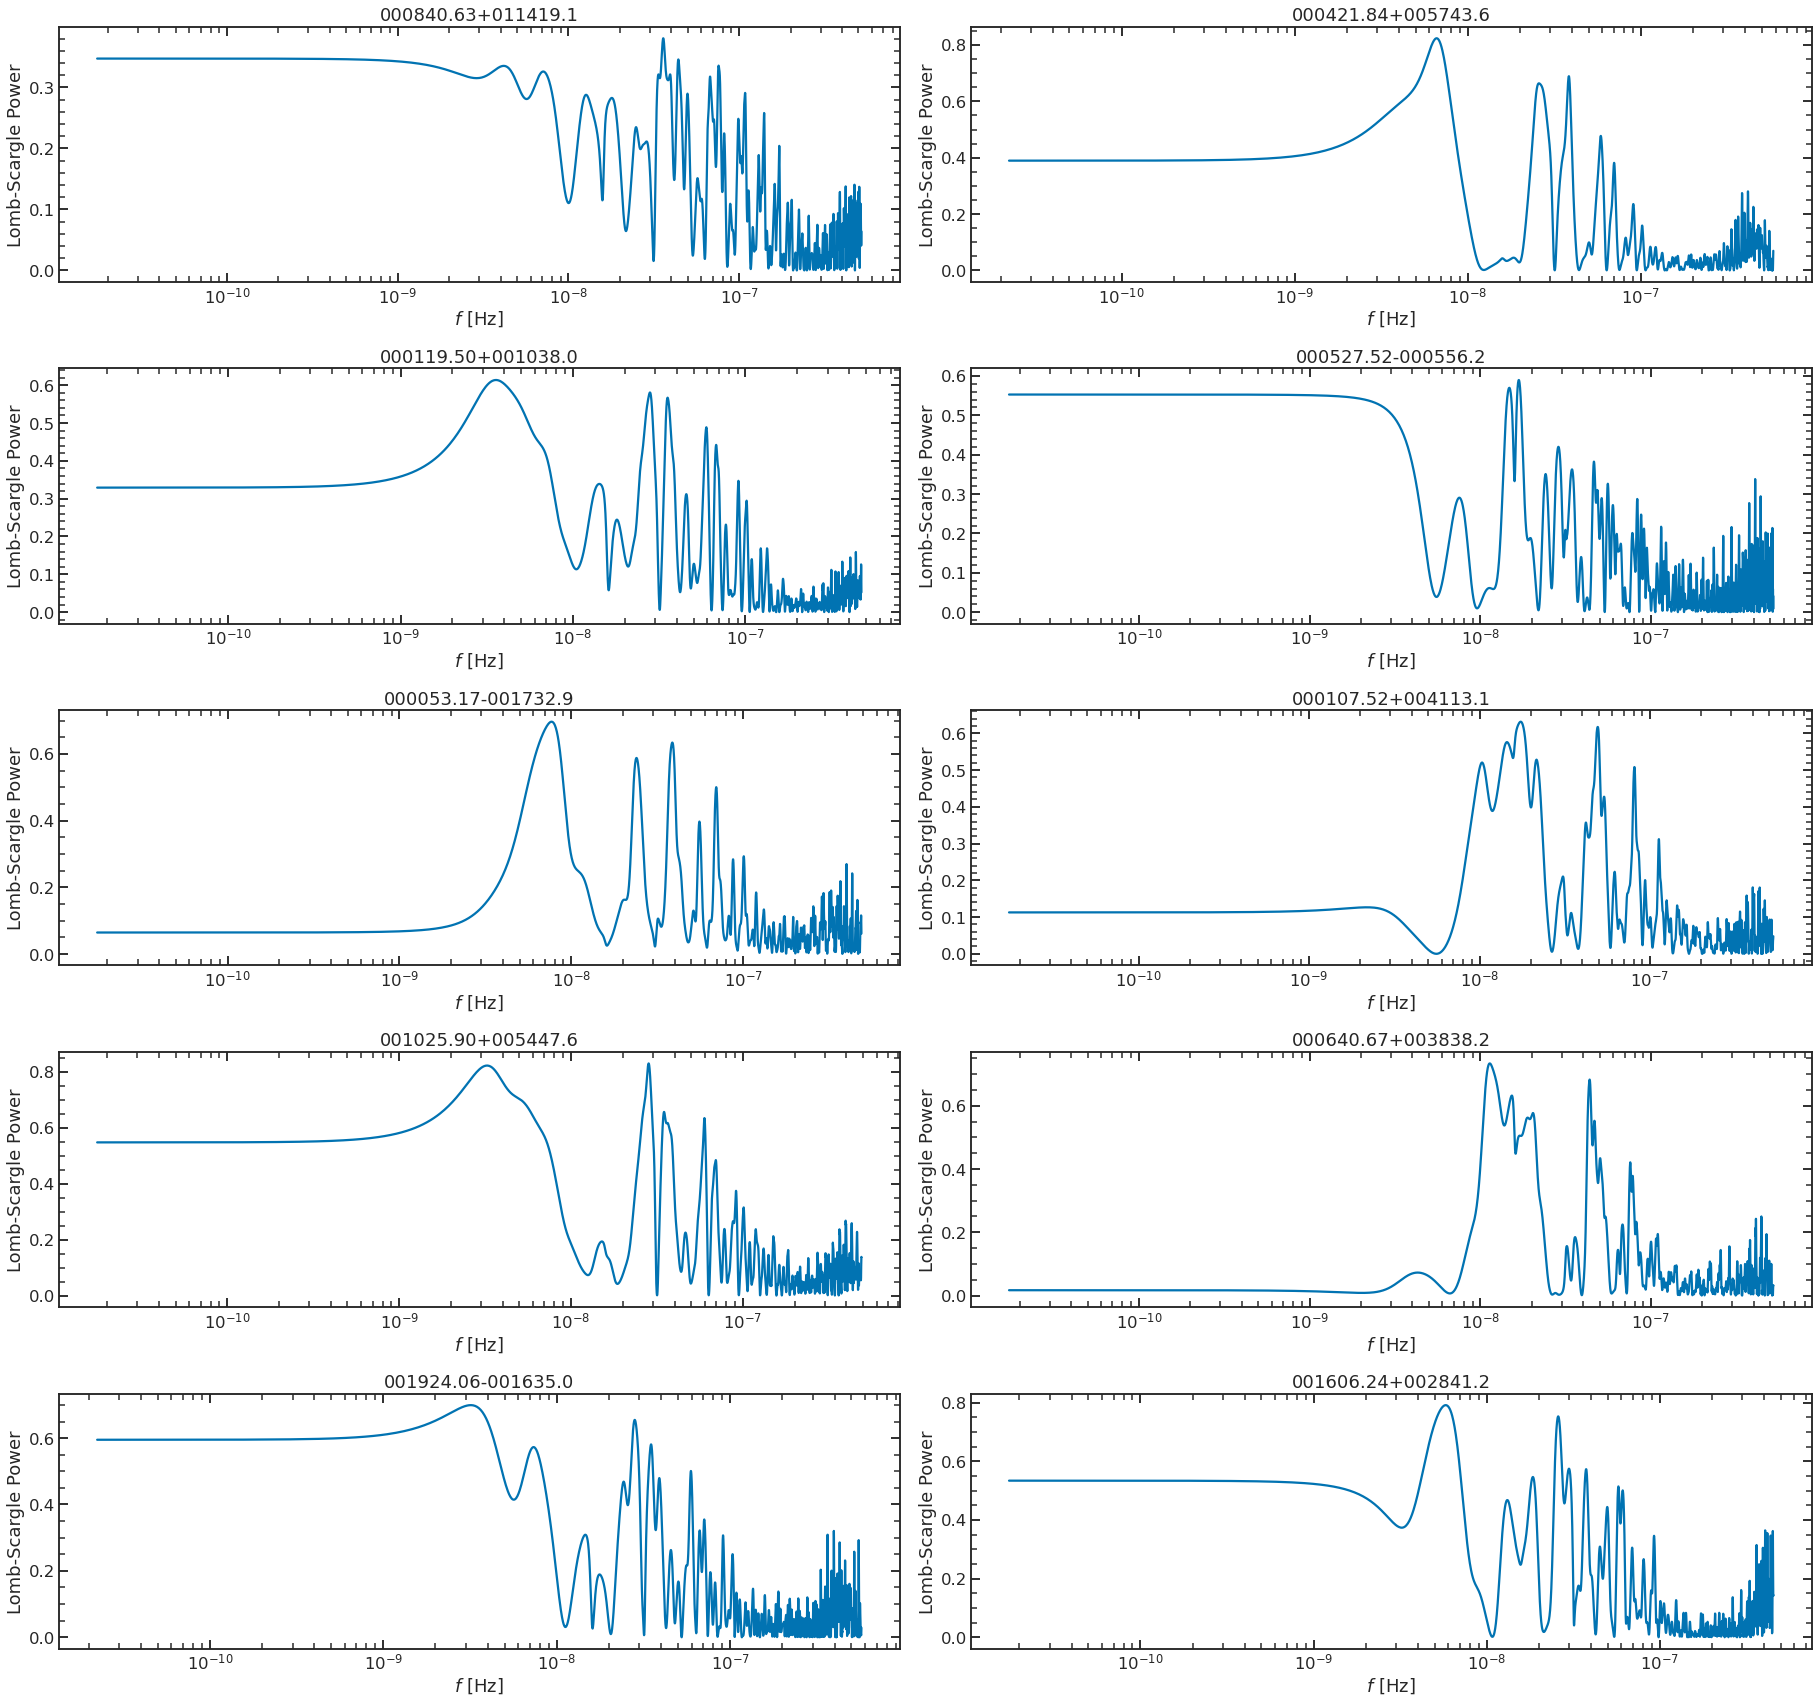

In [12]:
plot_lomb_scargle_psd(sdss_catalog[:10], n_cols=2, filename='sdss_periodograms', band='g')

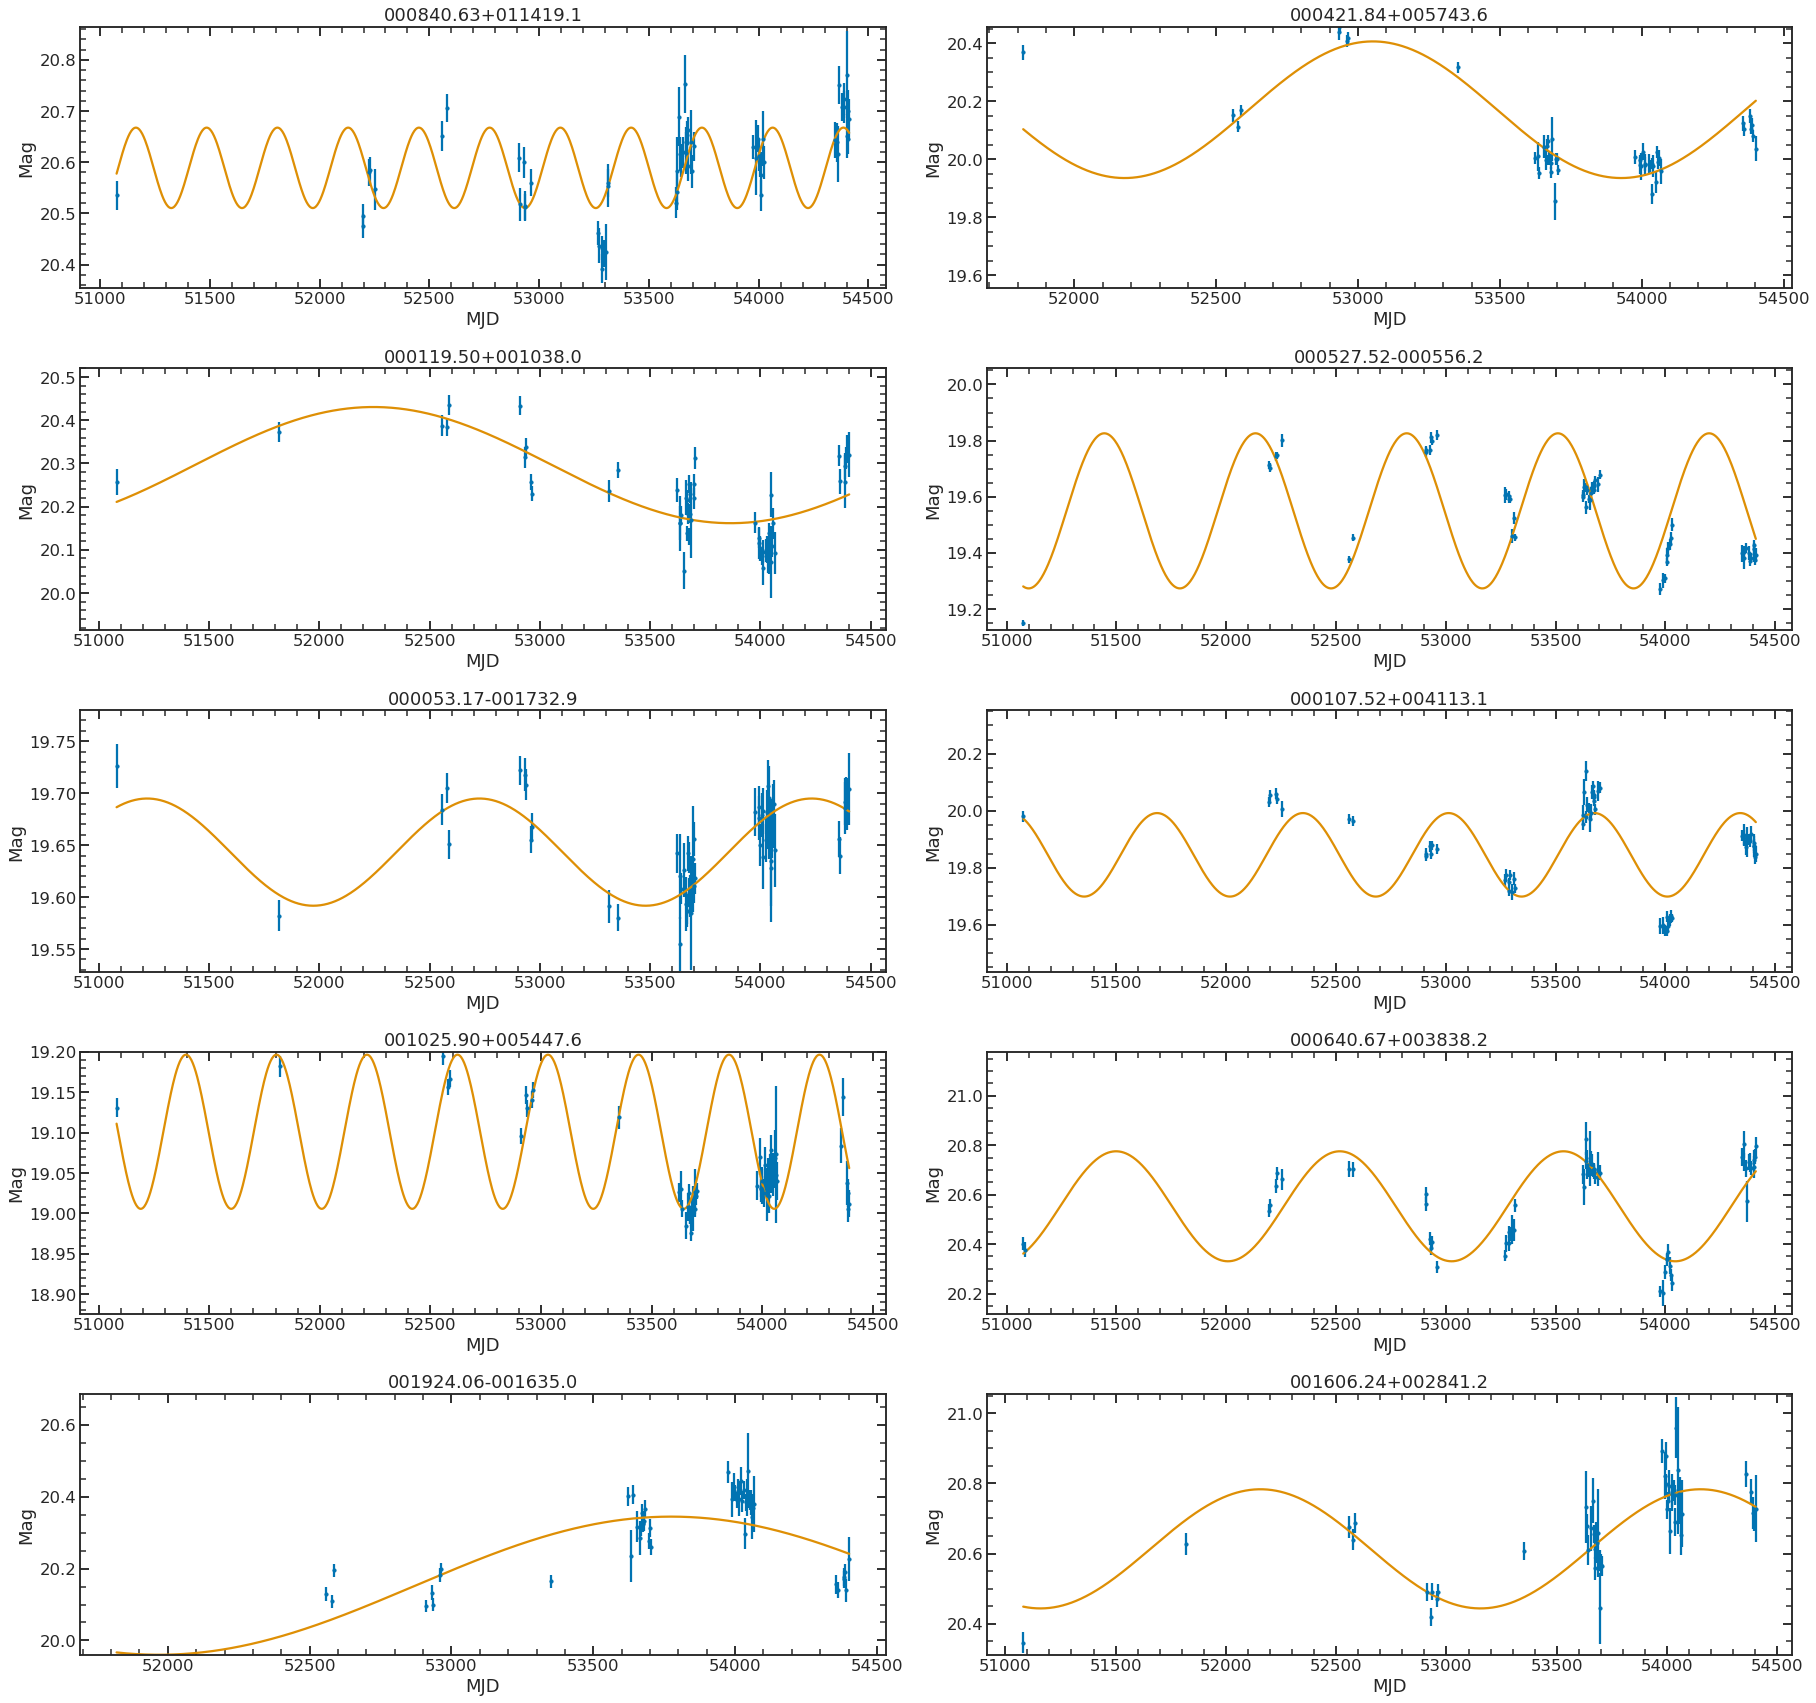

In [13]:
plot_lightcurve(sdss_catalog[:10], model=True, filename='sdss_lightcurves_model', band='g')

## Periodicity search

Now we'll perform a search for periodicity in our sources.

In [14]:
def qso_fap(qso, band=None):
    if band is not None:
        mjd_tag = f'MJD_{band}'
        mag_tag = f'{band}'
        magerr_tag = f'{band}_err'
        
        lc_cols = ['MJD_u', 'u', 'u_err',
                   'MJD_g', 'g', 'g_err',
                   'MJD_r', 'r', 'r_err',
                   'MJD_i', 'i', 'i_err',
                   'MJD_z', 'z', 'z_err',
                   'ra_median', 'decl_median']
    else:
        mjd_tag = 'MJD'
        mag_tag = 'Mag'
        magerr_tag = 'Magerr'
        
        lc_cols = ['Mag', 'Magerr', 'MJD']
    
    filepath = qso['lightcurve']
        
    if band is not None:
        with open(filepath) as f:
            lc = pd.read_csv(f, names=lc_cols, sep='\s+')
    else:
        with open(filepath) as f:
            lc = pd.read_csv(f, names=lc_cols, sep=',', header=0)

    lc = lc[lc[mag_tag] >= 0]  # remove contaminated data points because there are no quasars that bright
        
    mjd = (lc[mjd_tag].values * u.day).to(u.s)  # convert MJD to sec
    mag = lc[mag_tag].values * u.mag  # for now we'll only search over visual magnitudes
    magerr = lc[magerr_tag].values * u.mag
    
    t_obs = (np.max(mjd) - np.min(mjd)).value

    ls = LombScargle(mjd, mag, magerr)

    # calculate the frequency and significance
    try:
        frequency, power = ls.autopower(samples_per_peak=100)
    except ValueError as e:
    #     print(":(")
        print(filepath)
        print(lc)
        raise e
    best_frequency = frequency[np.argmax(power)].value  # Hz
    # p_det = ls.false_alarm_probability(power.max(), method='bootstrap')
    p_det = ls.false_alarm_probability(power.max(), method='baluev').value
    return pd.Series([t_obs, best_frequency, 2 * best_frequency, p_det])
    


def periodic_lightcurve_search(catalog, band=None):
    """Perform a search for periodic lightcurves.
    
    """
    catalog[['t_obs', 'f_orbit', 'f_gw', 'fap']] = catalog.progress_apply(qso_fap, axis=1, args=(band,))
    return catalog

### CRTS

In [15]:
crts_catalog = periodic_lightcurve_search(crts_catalog)
crts_catalog['t_per'] = 1 / crts_catalog['f_orbit']
crts_catalog['n_per'] = crts_catalog['t_obs'] / crts_catalog['t_per']
crts_catalog

  0%|          | 0/98 [00:00<?, ?it/s]

,Name,dbId,RA,Dec,Redshift,BH_mass,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per
0,UM234,2,5.763333,1.259417,0.729,9.19,./data/lightcurves/CRTS/2,1.794004e-63,6.411040e-09,1.282208e-08,2.612681e+08,1.559809e+08,1.675
1,SDSSJ014350.13+141453.0,3,25.958333,14.248583,1.438,9.21,./data/lightcurves/CRTS/3,2.450322e-23,2.571834e-06,5.143667e-06,2.556484e+08,3.888277e+05,657.485
2,US3204,6,42.370417,1.156944,0.954,8.95,./data/lightcurves/CRTS/6,5.551453e-53,7.204883e-09,1.440977e-08,2.560763e+08,1.387948e+08,1.845
3,RXSJ04117+1324,8,62.945417,13.404583,0.277,8.16,./data/lightcurves/CRTS/8,6.202502e-05,4.129011e-06,8.258022e-06,2.600417e+08,2.421887e+05,1073.715
4,2MASSJ04352649-1643460,10,68.860417,-16.729361,0.098,7.78,./data/lightcurves/CRTS/10,1.498826e-56,8.289651e-09,1.657930e-08,2.527248e+08,1.206323e+08,2.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,SDSSJ170616.24+370927.0,102,256.567500,37.157500,1.267,9.10,./data/lightcurves/CRTS/102,2.662365e-31,8.146487e-09,1.629297e-08,2.645312e+08,1.227523e+08,2.155
94,FBQSJ17239+3748,104,260.976250,37.811583,0.828,9.38,./data/lightcurves/CRTS/104,2.391944e-82,5.938410e-09,1.187682e-08,2.652225e+08,1.683952e+08,1.575
95,SDSSJ172656.96+600348.5,105,261.737083,60.063639,0.991,9.15,./data/lightcurves/CRTS/105,3.033669e-11,5.943093e-09,1.188619e-08,2.347262e+08,1.682625e+08,1.395
96,SDSSJ221016.97+122213.9,108,332.570833,12.370556,0.717,9.00,./data/lightcurves/CRTS/108,2.560023e-11,8.654621e-09,1.730924e-08,2.640208e+08,1.155452e+08,2.285


In [65]:
crts_catalog['fap'].max()

0.0004512982802449801

In [66]:
1 - 0.999936657516334

6.334248366601791e-05

In [67]:
1 - 0.999534741841929

0.00046525815807096915

### SDSS

In [16]:
sdss_catalog = periodic_lightcurve_search(sdss_catalog, band='g')
sdss_catalog['t_per'] = 1 / sdss_catalog['f_orbit']
sdss_catalog['n_per'] = sdss_catalog['t_obs'] / sdss_catalog['t_per']
sdss_catalog

  0%|          | 0/9254 [00:00<?, ?it/s]

,Name,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per
0,000840.63+011419.1,70,2.16931,1.23865,1.0737,7.52,1.52,./data/lightcurves/SDSS/70,5.805738e-04,3.591607e-08,7.183214e-08,2.883110e+08,2.784269e+07,10.355
1,000421.84+005743.6,98,1.09103,0.96212,0.7929,8.82,0.17,./data/lightcurves/SDSS/98,3.678895e-16,6.609371e-09,1.321874e-08,2.231680e+08,1.513003e+08,1.475
2,000119.50+001038.0,233,0.33129,0.17723,1.6209,8.92,0.20,./data/lightcurves/SDSS/233,1.721954e-08,3.572209e-09,7.144417e-09,2.869373e+08,2.799389e+08,1.025
3,000527.52-000556.2,1018,1.36470,-0.09896,0.6124,9.02,0.27,./data/lightcurves/SDSS/1018,7.635328e-09,1.680477e-08,3.360954e-08,2.883110e+08,5.950692e+07,4.845
4,000053.17-001732.9,1310,0.22156,-0.29249,2.7571,9.25,0.06,./data/lightcurves/SDSS/1310,1.458843e-11,7.684605e-09,1.536921e-08,2.869373e+08,1.301303e+08,2.205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9249,022346.50+011526.7,2004174,35.94376,1.25743,2.4168,8.26,0.17,./data/lightcurves/SDSS/2004174,9.540070e-07,8.133521e-09,1.626704e-08,2.883130e+08,1.229480e+08,2.345
9250,022350.32+011433.2,2020108,35.95967,1.24256,1.8007,8.45,0.51,./data/lightcurves/SDSS/2020108,1.022737e-13,4.838491e-09,9.676983e-09,2.883130e+08,2.066760e+08,1.395
9251,025610.91+011324.3,2474692,44.04546,1.22344,0.9871,8.02,0.33,./data/lightcurves/SDSS/2474692,1.461186e-06,1.324414e-08,2.648827e-08,2.880520e+08,7.550511e+07,3.815
9252,034127.35+011514.2,4952501,55.36400,1.25396,3.1043,9.18,0.20,./data/lightcurves/SDSS/4952501,2.869015e-06,2.202467e-09,4.404935e-09,2.883130e+08,4.540362e+08,0.635


### Apply population cuts

Next we'll start cutting this catalog down to our actual candidates by applying the following the following requirements:
 * False alarm probability (FAP): $P(D | M_{\rm noise}) < 0.003$ (i.e. $\sim 3 \sigma$ upper limit).
   * Caveats:
     * This is the probability of obserrving data $D$ given a noise-only model $M_{\rm noise}$
     * It's worth noting that this is really just a proxy for $P(M_{\rm noise} | D)$. In actuality, $P(M_{\rm noise} | D) = \frac{P(D | M_{\rm noise}) P(M_{\rm noise})}{P(D)}$. However we do not have the model evidence $P(D)$, nor do we have a good handle on $P(M_{\rm noise})$.
     * A better statistic to calculate would be $P(M_{\rm periodic} | D) = \frac{P(D | M_{\rm periodic}) P(M_{\rm periodic})}{P(D)}$, though this is subject to the same issues as in the above point for the noise-only model.
     * We can, however, calculate $P(M_{\rm periodic} | D)$ if we assume the uncertainties are Gaussian.
 * Observed periods: $N_{\rm obs} \geq 1.5$.

In [71]:
sdss_catalog = sdss_catalog[~np.isnan(sdss_catalog['fap'])]  # remove NaN entries

# fap_cut = 1 - 0.997300203936740  # 3 sigma
# fap_cut = 1 - 0.999534741841929  # 3.5 sigma
# fap_cut = 1 - 0.999936657516334  # 4 sigma
# fap_cut = 1 - 0.999993204653751  # 4.5 sigma
fap_cut = 1 - 0.999999426696856  # 5 sigma
n_per_cut = 1.5

fap_mask = sdss_catalog['fap'] < fap_cut
n_per_mask = sdss_catalog['n_per'] >= n_per_cut

candidate_catalog = sdss_catalog[fap_mask & n_per_mask]
candidate_catalog

,Name,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per
3,000527.52-000556.2,1018,1.36470,-0.09896,0.6124,9.02,0.27,./data/lightcurves/SDSS/1018,7.635328e-09,1.680477e-08,3.360954e-08,2.883110e+08,5.950692e+07,4.845
4,000053.17-001732.9,1310,0.22156,-0.29249,2.7571,9.25,0.06,./data/lightcurves/SDSS/1310,1.458843e-11,7.684605e-09,1.536921e-08,2.869373e+08,1.301303e+08,2.205
5,000107.52+004113.1,1327,0.28137,0.68699,1.3990,8.78,0.10,./data/lightcurves/SDSS/1327,2.183992e-10,1.742909e-08,3.485819e-08,2.883110e+08,5.737533e+07,5.025
6,001025.90+005447.6,1540,2.60796,0.91325,2.8573,9.16,0.06,./data/lightcurves/SDSS/1540,5.217493e-18,2.829693e-08,5.659385e-08,2.860735e+08,3.533953e+07,8.095
7,000640.67+003838.2,1580,1.66949,0.64395,1.3370,8.59,0.12,./data/lightcurves/SDSS/1580,4.765569e-14,1.135926e-08,2.271852e-08,2.883110e+08,8.803390e+07,3.275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9239,032952.16+010206.8,3750702,52.46737,1.03524,0.9245,8.90,0.07,./data/lightcurves/SDSS/3750702,1.455451e-26,1.263342e-08,2.526684e-08,2.869373e+08,7.915512e+07,3.625
9241,034008.54+010714.8,4910011,55.03559,1.12080,2.8302,9.99,0.21,./data/lightcurves/SDSS/4910011,3.160943e-09,9.243426e-09,1.848685e-08,2.883130e+08,1.081850e+08,2.665
9242,034414.17+010043.7,4945438,56.05907,1.01216,2.1732,9.09,0.24,./data/lightcurves/SDSS/4945438,2.139791e-12,7.440649e-09,1.488130e-08,2.869373e+08,1.343969e+08,2.135
9244,012934.33+011309.4,1010945,22.39304,1.21928,2.2370,8.38,0.17,./data/lightcurves/SDSS/1010945,1.229768e-11,1.777582e-08,3.555164e-08,2.883130e+08,5.625620e+07,5.125


We can also plot a histograms showing these cuts. Let's do that in both 1D and 2D because we're awesome.

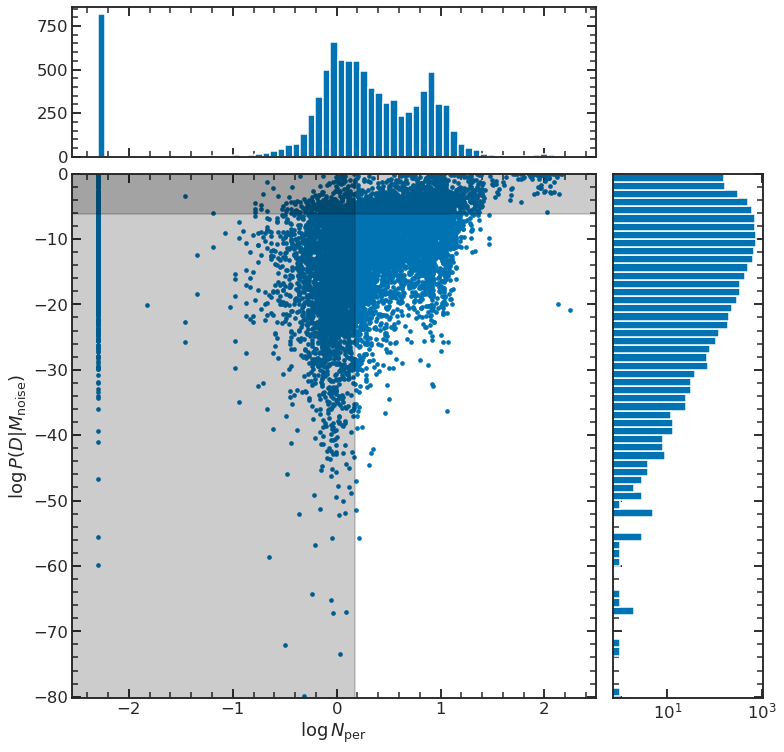

In [72]:
# based on code at https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    # binwidth = 0.25
    # xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    # lim = (int(xymax/binwidth) + 1) * binwidth

    # bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins='auto')
    ax_histy.hist(y, bins='scott', orientation='horizontal', log=True)
    

# start with a square Figure
fig = plt.figure(figsize=(12, 12))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(np.log10(sdss_catalog['n_per']), np.log10(sdss_catalog['fap']), ax, ax_histx, ax_histy)

# show the cuts
xmin, xmax = np.min(np.log10(sdss_catalog['n_per'])) - .25, np.max(np.log10(sdss_catalog['n_per'])) + .25
ymin, ymax = np.min(np.log10(sdss_catalog['fap'])) - .25, 0
# ymin, ymax = 0, 1
# xmin, xmax = ax.get_xlim()
# ymin, ymax = ax.get_ylim()
ax.fill_betweenx(np.linspace(ymin, ymax), xmin, np.log10(n_per_cut), color='k', alpha=.2)
ax.fill_between(np.linspace(xmin, xmax), np.log10(fap_cut), ymax, color='k', alpha=.2)

# ax_histx
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r'$\log N_{\rm per}$')
ax.set_ylabel(r'$\log P(D | M_{\rm noise})$')

plt.tight_layout()
plt.show()

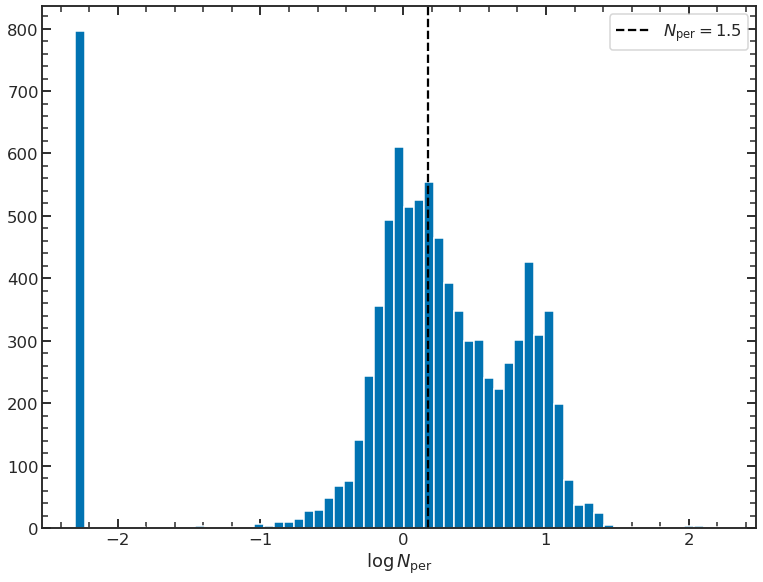

In [19]:
plt.figure()

plt.hist(np.log10(sdss_catalog[fap_mask]['n_per']), bins='auto')
plt.axvline(np.log10(n_per_cut), color='k', linestyle='--', label=r'$N_{\rm per} = 1.5$')

plt.xlabel(r'$\log N_{\rm per}$')

plt.legend()
plt.show()

#### Plot the best

Next we'll plot the 10 best candidates we have.

In [20]:
best_candidates = candidate_catalog.sort_values('fap')
best_candidates

,Name,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per
6072,025515.09+003740.5,2582415,43.81290,0.62793,1.0228,8.87,0.13,./data/lightcurves/SDSS/2582415,2.228702e-56,5.750601e-09,1.150120e-08,2.877960e+08,1.738949e+08,1.655
2626,013956.47+005028.3,956402,24.98533,0.84122,2.1370,9.44,0.25,./data/lightcurves/SDSS/956402,4.172276e-52,5.333706e-09,1.066741e-08,2.877924e+08,1.874869e+08,1.535
4058,221154.19+001238.8,1551602,332.97580,0.21078,1.2558,9.15,0.09,./data/lightcurves/SDSS/1551602,8.618995e-48,6.026639e-09,1.205328e-08,2.547025e+08,1.659300e+08,1.535
5389,023309.86+005025.9,2101201,38.29109,0.84054,2.5757,9.00,0.19,./data/lightcurves/SDSS/2101201,2.987679e-45,9.213796e-09,1.842759e-08,2.241204e+08,1.085329e+08,2.065
1815,010925.96-003739.0,604716,17.35817,-0.62752,1.3574,8.79,0.12,./data/lightcurves/SDSS/604716,1.715729e-43,7.383702e-09,1.476740e-08,2.877960e+08,1.354334e+08,2.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5693,025142.15-005403.0,2475517,42.92565,-0.90084,0.5192,8.36,0.36,./data/lightcurves/SDSS/2475517,2.737039e-03,7.494131e-08,1.498826e-07,2.876251e+08,1.334378e+07,21.555
4059,221037.48+003255.5,1551859,332.65619,0.54875,3.1609,9.61,0.09,./data/lightcurves/SDSS/1551859,2.749429e-03,6.960364e-09,1.392073e-08,2.535787e+08,1.436707e+08,1.765
4226,021035.82-010524.3,1607444,32.64928,-1.09009,1.9110,9.17,0.15,./data/lightcurves/SDSS/1607444,2.826253e-03,1.901112e-08,3.802224e-08,2.869373e+08,5.260079e+07,5.455
1176,232424.17+001011.8,359774,351.10074,0.16995,0.5854,8.58,0.23,./data/lightcurves/SDSS/359774,2.848818e-03,1.170484e-07,2.340969e-07,9.504612e+07,8.543472e+06,11.125


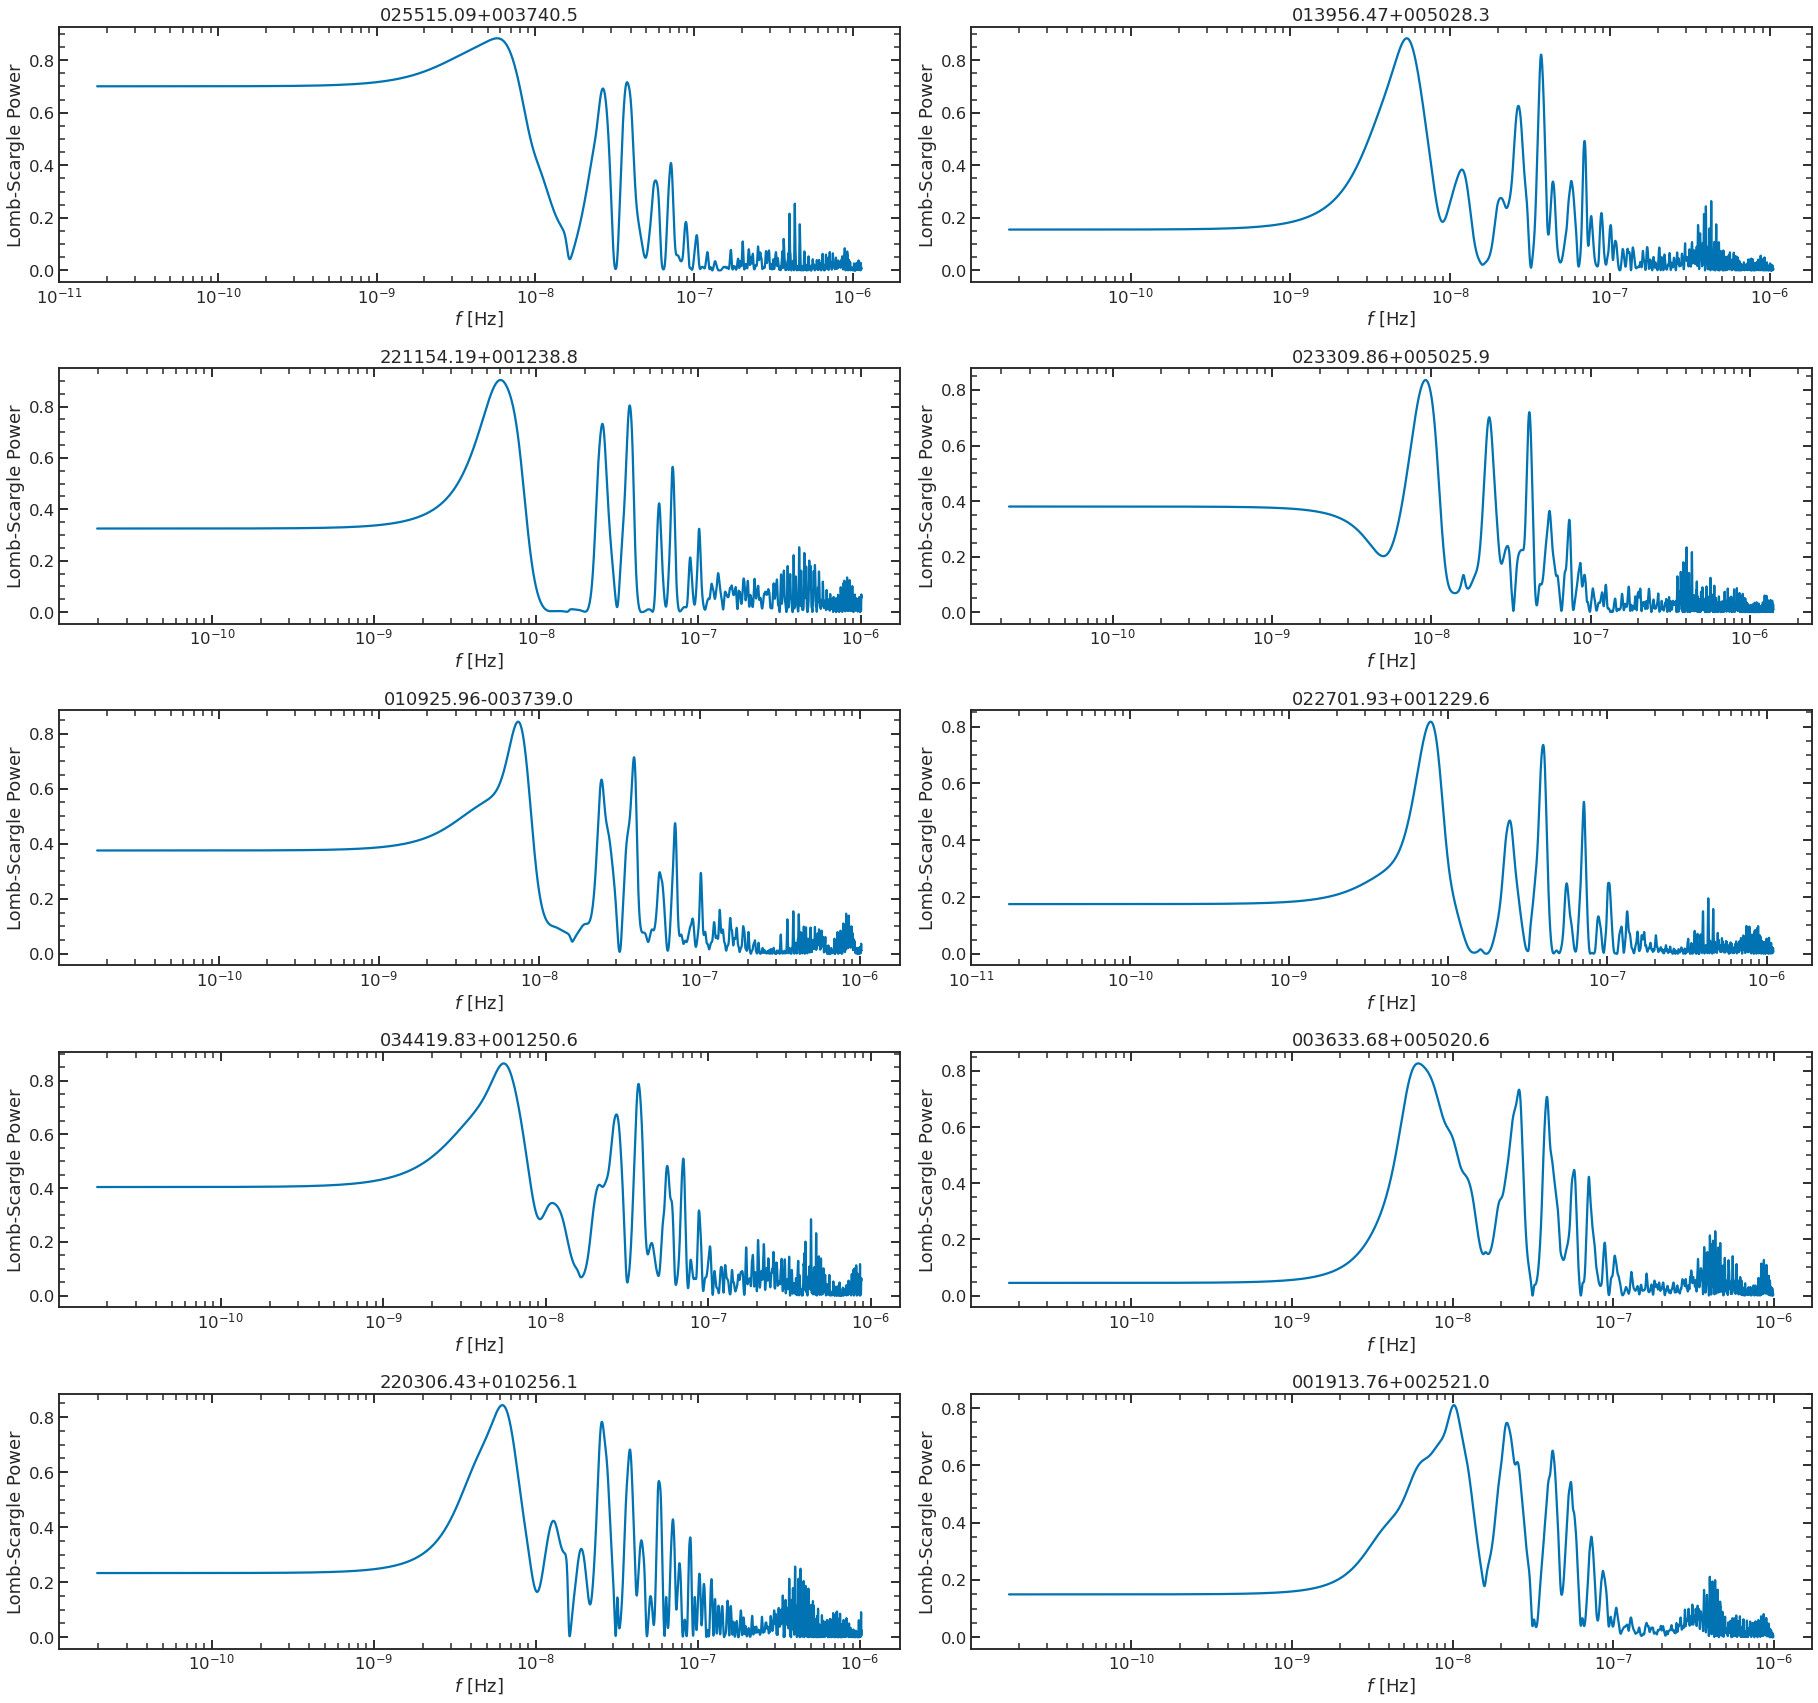

In [21]:
plot_lomb_scargle_psd(best_candidates[:10], n_cols=2, filename='sdss_periodograms', band='g')

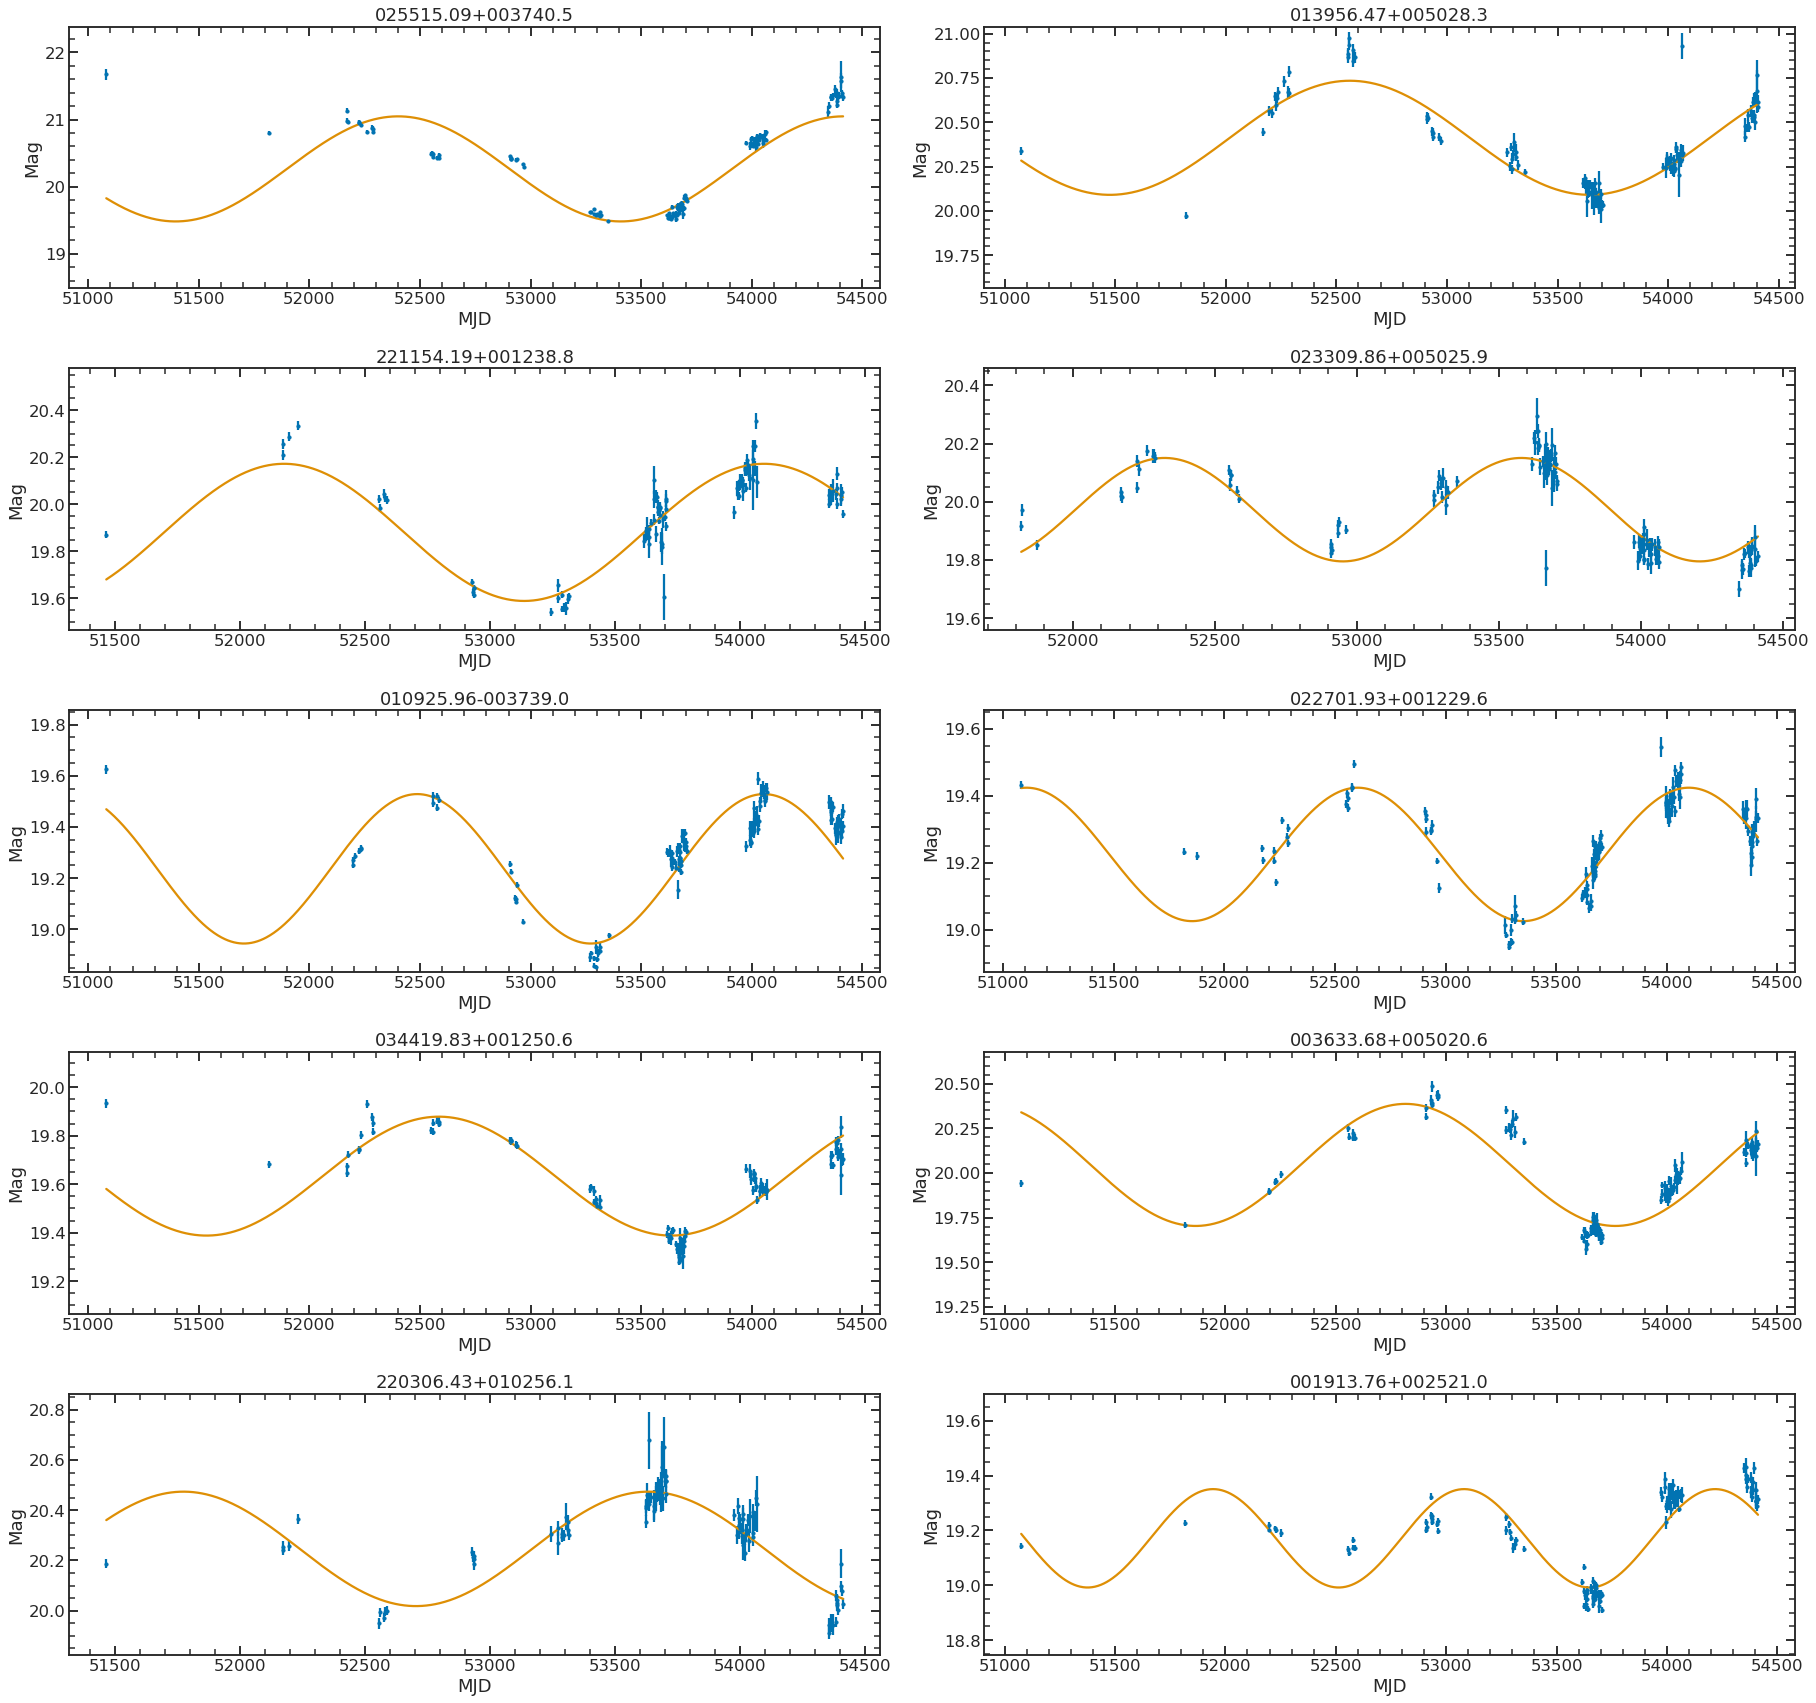

In [22]:
plot_lightcurve(best_candidates[:10], model=True, filename='sdss_lightcurves_model', band='g')

In [23]:
# n_plots = 10
# n_cols = 2
# n_rows = int(np.ceil(n_plots / n_cols))

# fig, ax = plt.subplots(n_rows, n_cols, figsize=(6.4 * 4, 9.6 / 2 * n_rows))
# # fig = plt.figure()
# # gs = fig.add_gridspec(int(np.ceil(n_plots / 2)), 2)

# best_candidates = candidate_catalog.sort_values('fap')

# for i, a in enumerate(ax.flatten()):
#     filepath = best_candidates['lightcurve'].iloc[i]
#     with open(filepath) as f:
#         lc = pd.read_csv(f, names=lc_cols, sep='\s+')
    
#     mjd = (lc['MJD_g'].values * u.day).to(u.s)  # convert MJD to sec
#     mag = lc['g'].values * u.mag  # for now we'll only search over visual magnitudes
#     magerr = lc['g_err'].values * u.mag

    
    
#     ls = LombScargle(mjd, mag, magerr)

#     frequency, power = ls.autopower(samples_per_peak=100)

#     best_frequency = frequency[np.argmax(power)]
#     t_fit = np.linspace(mjd.min(), mjd.max(), num=1000)
#     y_fit = ls.model(t_fit, best_frequency)
    
#     a.errorbar(lc['MJD_g'], lc['g'], yerr=lc['g_err'],
#                 marker='o', linestyle='none')
#     a.plot(t_fit.to(u.day), y_fit)
    
#     med = np.median(y_fit)
#     ylow = med - 3 * np.diff(np.quantile(y_fit, q=[.16, .5]))
#     yhigh = med + 3 * np.diff(np.quantile(y_fit, q=[.5, .84]))
#     a.set_ylim(ylow.value, yhigh.value)
    
#     a.set_xlabel('MJD')
#     a.set_ylabel('Mag')
#     a.set_title(best_candidates['Name'].iloc[i])

# plt.tight_layout()
# plt.savefig('./figures/best_candidates.pdf')
# plt.savefig('./figures/best_candidates.png')
# plt.show()

# Strain calculation

Finally we'll calculate strain for all of these candidates. The sky and polarization averaged strain of a source at some luminosity distance, $D_{\rm L}$, is (e.g., Mingarelli+ 2017)

$$
h = \sqrt{\frac{32}{5}} \frac{\mathcal{M}_{c}^{5 / 3} (\pi f (1 + z))^{2 / 3}}{D_{\rm L}},
$$

where $\mathcal{M}_{c}^{5 / 3} = \frac{q}{(1 + q)^{2}} M_{\rm tot}^{5 / 3}$ is the chirp mass, $z$ is the binary redshift, and $f$ is the GW frequency as observed on Earth.

In [24]:
import astropy.constants as const

In [25]:
# G = c = 1 geometric units
# Note that Hz is already geometric
GEO_MSUN = (u.Msun * (const.G / const.c ** 3)).to(u.s)
GEO_MPC = (u.Mpc / const.c).to(u.s)
# AU = (1 * u.au / const.c).to(u.s).value
# YEAR = (1 * u.yr).to(u.s).value
# HOUR = (1 * u.hr).to(u.s).value
# ERG = (u.erg * (const.G / (const.c ** 5))).to(u.s).value  # this is very tiny and might make using geometric units a pain for luminosities

In [26]:
def log_chirp_mass(log_total_mass, q=1):
    log_chirp_mass = log_total_mass
    log_chirp_mass += .6 * (np.log10(q) - 2 * np.log10(1 + q))
    return log_chirp_mass
    
    
def strain(log_mass, frequency, z, q=1, cosmo=cosmo):
    """
    Strain calculated in natural units.
    
    """
    # first convert everything to numpy arrays
    log_mass = np.array(log_mass)
    frequency = np.array(frequency)
    z = np.array(z)
    
    # calculate the chirp mass
    log_mass = log_mass + np.log10(GEO_MSUN.value)  # convert to geometric units
    log_m_chirp = log_chirp_mass(log_mass, q=q)
    
    # next calculate the luminosity distance
    # we need this in the denominator of the strain equation
    lum_dist = cosmo.luminosity_distance(z).to(u.Mpc).value
    log_lum_dist = np.log10(lum_dist) + np.log10(GEO_MPC.value)  # convert to geometric units

    f_r = frequency * (1 + z)  # rest frame frequency
    log_f_r = np.log10(f_r)  # already geometric
    
    return 10 ** log_strain(log_m_chirp, log_f_r, log_lum_dist)
    

def log_strain(log_chirp_mass, log_frequency, log_luminosity_distance):
    return .5 * np.log10(32 / 5) + (5 / 3) * log_chirp_mass + (2 / 3) * (np.log10(np.pi) + log_frequency) - log_luminosity_distance



In [27]:
crts_catalog['strain_ul'] = strain(crts_catalog['BH_mass'],
                                   crts_catalog['f_gw'],
                                   crts_catalog['Redshift'])
crts_catalog

,Name,dbId,RA,Dec,Redshift,BH_mass,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per,strain_ul
0,UM234,2,5.763333,1.259417,0.729,9.19,./data/lightcurves/CRTS/2,1.794004e-63,6.411040e-09,1.282208e-08,2.612681e+08,1.559809e+08,1.675,6.758986e-17
1,SDSSJ014350.13+141453.0,3,25.958333,14.248583,1.438,9.21,./data/lightcurves/CRTS/3,2.450322e-23,2.571834e-06,5.143667e-06,2.556484e+08,3.888277e+05,657.485,2.150212e-15
2,US3204,6,42.370417,1.156944,0.954,8.95,./data/lightcurves/CRTS/6,5.551453e-53,7.204883e-09,1.440977e-08,2.560763e+08,1.387948e+08,1.845,2.263018e-17
3,RXSJ04117+1324,8,62.945417,13.404583,0.277,8.16,./data/lightcurves/CRTS/8,6.202502e-05,4.129011e-06,8.258022e-06,2.600417e+08,2.421887e+05,1073.715,2.508303e-16
4,2MASSJ04352649-1643460,10,68.860417,-16.729361,0.098,7.78,./data/lightcurves/CRTS/10,1.498826e-56,8.289651e-09,1.657930e-08,2.527248e+08,1.206323e+08,2.095,2.645123e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,SDSSJ170616.24+370927.0,102,256.567500,37.157500,1.267,9.10,./data/lightcurves/CRTS/102,2.662365e-31,8.146487e-09,1.629297e-08,2.645312e+08,1.227523e+08,2.155,3.389825e-17
94,FBQSJ17239+3748,104,260.976250,37.811583,0.828,9.38,./data/lightcurves/CRTS/104,2.391944e-82,5.938410e-09,1.187682e-08,2.652225e+08,1.683952e+08,1.575,1.181092e-16
95,SDSSJ172656.96+600348.5,105,261.737083,60.063639,0.991,9.15,./data/lightcurves/CRTS/105,3.033669e-11,5.943093e-09,1.188619e-08,2.347262e+08,1.682625e+08,1.395,4.141909e-17
96,SDSSJ221016.97+122213.9,108,332.570833,12.370556,0.717,9.00,./data/lightcurves/CRTS/108,2.560023e-11,8.654621e-09,1.730924e-08,2.640208e+08,1.155452e+08,2.285,4.045234e-17


In [28]:
candidate_catalog['strain_ul'] = strain(candidate_catalog['BH_mass'],
                                        candidate_catalog['f_gw'],
                                        candidate_catalog['Redshift'])
candidate_catalog

,Name,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per,strain_ul
0,000840.63+011419.1,70,2.16931,1.23865,1.0737,7.52,1.52,./data/lightcurves/SDSS/70,5.805738e-04,3.591607e-08,7.183214e-08,2.883110e+08,2.784269e+07,10.355,2.454329e-19
3,000527.52-000556.2,1018,1.36470,-0.09896,0.6124,9.02,0.27,./data/lightcurves/SDSS/1018,7.635328e-09,1.680477e-08,3.360954e-08,2.883110e+08,5.950692e+07,4.845,7.908133e-17
4,000053.17-001732.9,1310,0.22156,-0.29249,2.7571,9.25,0.06,./data/lightcurves/SDSS/1310,1.458843e-11,7.684605e-09,1.536921e-08,2.869373e+08,1.301303e+08,2.205,3.119804e-17
5,000107.52+004113.1,1327,0.28137,0.68699,1.3990,8.78,0.10,./data/lightcurves/SDSS/1327,2.183992e-10,1.742909e-08,3.485819e-08,2.883110e+08,5.737533e+07,5.025,1.513501e-17
6,001025.90+005447.6,1540,2.60796,0.91325,2.8573,9.16,0.06,./data/lightcurves/SDSS/1540,5.217493e-18,2.829693e-08,5.659385e-08,2.860735e+08,3.533953e+07,8.095,5.133218e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9242,034414.17+010043.7,4945438,56.05907,1.01216,2.1732,9.09,0.24,./data/lightcurves/SDSS/4945438,2.139791e-12,7.440649e-09,1.488130e-08,2.869373e+08,1.343969e+08,2.135,1.973057e-17
9244,012934.33+011309.4,1010945,22.39304,1.21928,2.2370,8.38,0.17,./data/lightcurves/SDSS/1010945,1.229768e-11,1.777582e-08,3.555164e-08,2.883130e+08,5.625620e+07,5.125,2.261177e-18
9248,021617.28+011234.2,1600743,34.07203,1.20951,2.1872,9.10,0.16,./data/lightcurves/SDSS/1600743,1.157501e-10,8.896581e-09,1.779316e-08,2.883130e+08,1.124027e+08,2.565,2.298303e-17
9249,022346.50+011526.7,2004174,35.94376,1.25743,2.4168,8.26,0.17,./data/lightcurves/SDSS/2004174,9.540070e-07,8.133521e-09,1.626704e-08,2.883130e+08,1.229480e+08,2.345,7.991279e-19


## Comparison to Sensitivity Upper Limits

Finally we'll compare these strain upper limits to sky and polarization averaged upper limits on sensitivity. We'll use Jeff Hazboun's `hasasia` package to build our upper limit curves.

In [29]:
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky

In [30]:
def sky_ave_detect(sm,snr=3):
    snr /= 4
    snr *= np.sqrt(32 / 5)  # account for differences in strain definitions
    return snr*np.sqrt(np.mean(sm.S_eff, axis=1)/sm.Tspan)

### Current sensitivity curves

In [31]:
# NANOGrav 11-yr data
with open('data/h_sens/ng11yr_sky_sensitivity_wn.has','rb') as fin:
    SM_ng11 = pickle.load(fin)

In [32]:
# PPTA data
ppta_dr1 = pd.read_csv('data/h_sens/PPTAdr1_hsensitivity.txt', header=None, names=['f_gw', 'h_sens'])
ppta_dr2 = pd.read_csv('data/h_sens/PPTAdr2_hsensitivity.txt', header=None, names=['f_gw', 'h_sens'])

In [33]:
from scipy.stats import rv_histogram

import healpy as hp
#import plot #Script originally written by Leo Stein for making pretty sky maps. 

# Setting various healpy quantities and GW source sky positions.
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [34]:
def tspan_filter(psrs,tspan_min=3):
    return [p for p in psrs if hsen.get_Tspan([p])>=tspan_min]

In [35]:
freqs = np.logspace(np.log10(1e-9), np.log10(1e-7), 500)
freqs = np.sort(np.append(freqs, candidate_catalog['f_gw'].to_numpy()))

In [36]:
# IPTA DR2 -- following Jeff Hazboun's code
ipta_dr2_noise = np.genfromtxt('data/h_sens/ipta_dr2_rms.txt', delimiter='\t', 
                               skip_header=1,
                               dtype='U20, f4, f4, f4, f4',
                               names=['psr','theta', 'phi','wn','tspan']
                              )

# generate random cadences from NG 11-yr cadences
ng11yr_psrs=np.loadtxt('data/h_sens/ng11yr_psrs.txt',
                       dtype=[('psr', 'U32'), ('telescope', 'U32'), ('full',float),
                              ('wn',float), ('A_rn',float), ('gamma',float),
                              ('theta',float),('phi',float),('cadence',float),('tspan',float)],
                       delimiter=',',
                       skiprows=1)

cad_hist = np.histogram(2*ng11yr_psrs['cadence'], bins=20, density=True)
cad_rv = rv_histogram(cad_hist)
cad_ipta = cad_rv.rvs(size=63)

# grab pulsar positions, noises, timespans, and mock cadences
tspans_ipta = ipta_dr2_noise['tspan']
cad_ipta = cad_ipta
phi_ipta = ipta_dr2_noise['phi']
theta_ipta = ipta_dr2_noise['theta']
sigmas_ipta = ipta_dr2_noise['wn']*1e-6

# simulate the PTA
psrs_sim_dr2 = hsim.sim_pta(timespan=tspans_ipta,cad=cad_ipta,
                             sigma=sigmas_ipta,
                             phi=phi_ipta,theta=theta_ipta,uneven=True)

# calculate pulsar spectra
specs_dr2 = []
for p in tspan_filter(psrs_sim_dr2):
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs_dr2.append(sp)
    
# create skymap
SM_dr2 = hsky.SkySensitivity(specs_dr2, theta_gw, phi_gw)

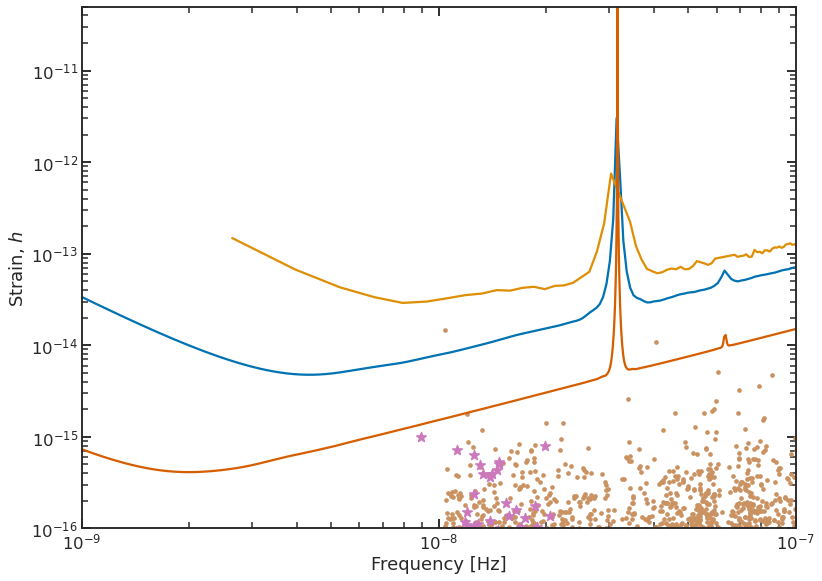

In [37]:
# sensitivity curves
plt.loglog(SM_ng11.freqs, sky_ave_detect(SM_ng11, snr=3), color=cs[0], label="NG 11-yr")
plt.loglog(ppta_dr1['f_gw'], ppta_dr1['h_sens'], color=cs[1], label='PPTA DR1')
plt.loglog(SM_dr2.freqs, sky_ave_detect(SM_dr2, snr=3), color=cs[3], label="IPTA DR2")
# plt.loglog(ppta_dr2['f_gw'], ppta_dr2['h_sens'], color=cs[2], label='PPTA DR2 (preliminary?)')

# binary candidates
plt.scatter(candidate_catalog['f_gw'],
            candidate_catalog['strain_ul'],
            color=cs[5],
            label='SDSS Candidates',
           )

plt.scatter(crts_catalog['f_gw'],
            crts_catalog['strain_ul'],
            color=cs[4], 
            marker='*',
            s=100,
            label='CRTS Candidates',
            # zorder=10,
           )


plt.xlim(1e-9, 1e-7)
plt.ylim(1e-16, 5e-11)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain, $h$')

# plt.legend()
plt.show()

#### DR2 Detectable Candidates

There is one SDSS candidate here that could be detectable by IPTA DR2. Let's take a closer look.

In [38]:
sorted_candidates = candidate_catalog.sort_values('f_gw')
candidate_frequency_mask = np.in1d(np.sort(SM_dr2.freqs), sorted_candidates['f_gw'])
ipta_dr2_comparison_strain = sky_ave_detect(SM_dr2, snr=3)[candidate_frequency_mask]

ipta_dr2_candidate = sorted_candidates[sorted_candidates['strain_ul'] >= ipta_dr2_comparison_strain]
ipta_dr2_candidate

,Name,dbId,RA,Dec,Redshift,BH_mass,BH_mass_err,lightcurve,fap,f_orbit,f_gw,t_obs,t_per,n_per,strain_ul
6051,024549.96-000051.8,2577645,41.45818,-0.01441,1.2900,10.76,0.25,./data/lightcurves/SDSS/2577645,1.316199e-23,5.220021e-09,1.044004e-08,2.883130e+08,1.915701e+08,1.505,1.449420e-14
5533,213054.48+011500.4,2212556,322.72702,1.25013,2.5097,10.59,0.05,./data/lightcurves/SDSS/2212556,1.138301e-14,2.029691e-08,4.059382e-08,2.549649e+08,4.926859e+07,5.175,1.092773e-14


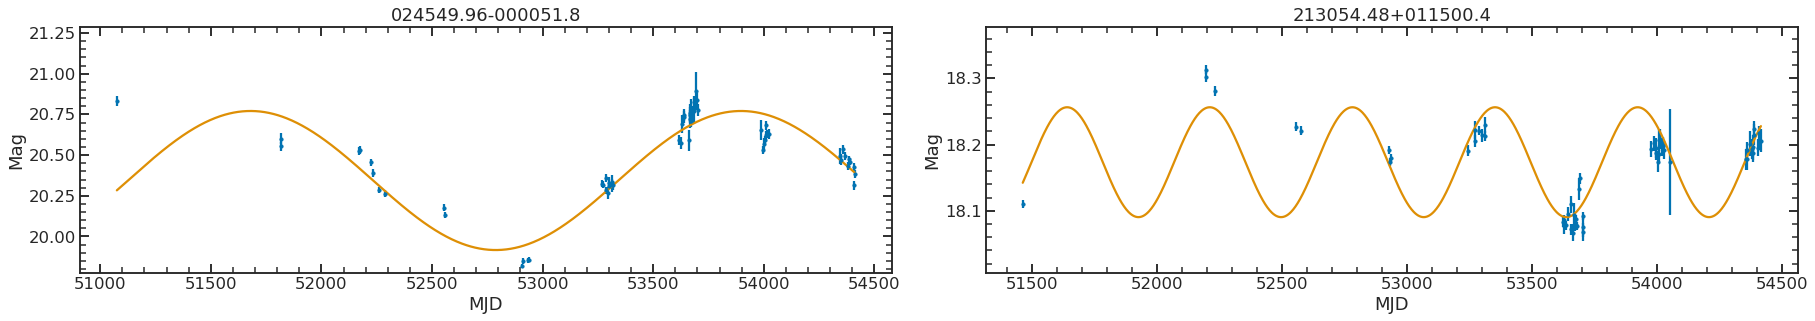

In [39]:
plot_lightcurve(ipta_dr2_candidate, n_cols=2, model=True, filename='ipta_dr2_candidate_lightcurves', band='g')

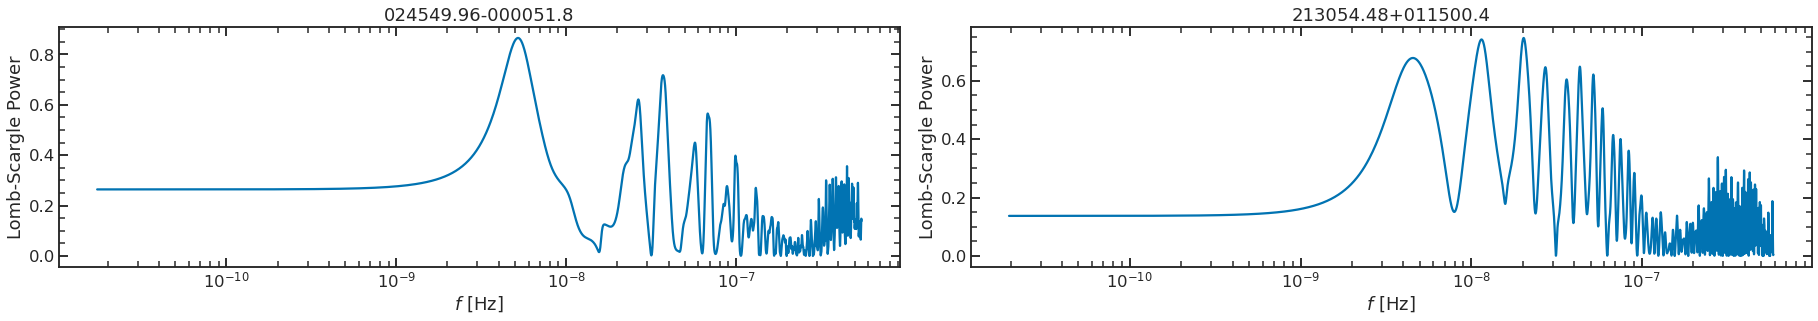

In [40]:
plot_lomb_scargle_psd(ipta_dr2_candidate, n_cols=2, filename='ipta_dr2_candidates_lomb_scargle', band='g')

### Predictions

Next we'll make predictions for NG 12.5-yr, IPTA DR3, SKA1, and SKA2 sensitivity curves to compare to.

In [41]:
# # first let's do some fake arrays
# # later we'll try using real pulsars
# # we can also use this as a basis for predictions for SKA
# # instantiate 34 random pulsars
# phi = np.random.uniform(0, 2*np.pi,size=34)
# cos_theta = np.random.uniform(-1,1,size=34)
# #This ensures a uniform distribution across the sky.
# theta = np.arccos(cos_theta)

In [42]:
# # next we give them some random timespans
# timespan=[11.4 for ii in range(10)]
# timespan.extend([3.0 for ii in range(24)])

In [43]:
# # create the simulated pulsars
# psrs = hsim.sim_pta(timespan=timespan, cad=23, sigma=1e-7,
#                     phi=phi,theta=theta)

In [44]:
# # this gives us red/time-correlated noise for our pulsars
# psrs2 = hsim.sim_pta(timespan=timespan,cad=23,sigma=1e-7,
#                      phi=phi,theta=theta,
#                      A_rn=6e-16,alpha=-2/3.,freqs=freqs)

In [45]:
# # now we calculate spectra for each pulsar
# spectra = []
# for p in psrs:
#     sp = hsen.Spectrum(p, freqs=freqs)
#     sp.NcalInv
#     spectra.append(sp)
    
# spectra2 = []
# for p in psrs2:
#     sp = hsen.Spectrum(p, freqs=freqs)
#     sp.NcalInv
#     spectra2.append(sp)

In [46]:
# # next we build sensitivity curves
# sc1a = hsen.GWBSensitivityCurve(spectra)
# sc1b = hsen.DeterSensitivityCurve(spectra)
# sc2a = hsen.GWBSensitivityCurve(spectra2)
# sc2b = hsen.DeterSensitivityCurve(spectra2)

# Uncertainty Estimation

The Lomb-Scargle method doesn't give us actual uncertainties on the parameteers, so we'll try a few methods to estimate those

## Markov Chain Monte Carlo

Next we'll use MCMC to get a handle on our model uncertainties.

In [47]:
# def periodic_model(t, log_f, th0, th1, th2):
#     f = 10 ** log_f
#     sin_term = th1 * np.sin(2 * np.pi * f * t)
#     cos_term = th2 * np.cos(2 * np.pi * f * t)
    
#     return th0 + sin_term + cos_term

In [48]:
# theta_init = np.array([np.log10(best_frequency.value)])
# model_params = ls.model_parameters(best_frequency)
# theta_init = np.append(theta_init, model_params.value)
# theta_init[1] += ls.offset().value  # accounts for the missing offset component from centering data (dumb)

In [49]:
# plt.figure()
# plt.errorbar(qso_J1139['MJD'], qso_J1139['Mag'], yerr=qso_J1139['Magerr'],
#             marker='o', linestyle='none')
# plt.plot(t_fit.to(u.day), periodic_model(t_fit.value, *theta_init), label="Us")
# plt.plot(t_fit.to(u.day), y_fit, label="astropy")
# plt.xlabel('MJD')
# plt.ylabel('Mag')
# plt.legend()
# plt.show()

In [50]:
# # define our MCMC likelihoods
# def log_likelihood(theta, t, mag, magerr):
#     log_f, th0, th1, th2 = theta
#     model = periodic_model(t, log_f, th0, th1, th2)
#     sigma2 = magerr ** 2
#     return -0.5 * np.sum((mag - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))


# def log_prior(theta):
#     log_f, th0, th1, th2 = theta
#     if -10 < log_f < -5 and 13 < th0 < 22 and -3 <= th1 <= 3 and 0 <= th2 <= 3:
#         return 0.0
#     return -np.inf


# def log_probability(theta, t, mag, magerr):
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood(theta, t, mag, magerr)

In [51]:
# # define our MCMC likelihoods
# def log_likelihood(theta, t, mag, magerr, th1, th2):
#     log_f, th0 = theta
#     model = periodic_model(t, log_f, th0, th1, th2)
#     sigma2 = magerr ** 2
#     return -0.5 * np.sum((mag - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))


# def log_prior(theta):
#     log_f, th0 = theta
#     if -10 < log_f < -5 and 13 < th0 < 22:
#         return 0.0
#     return -np.inf


# def log_probability(theta, t, mag, magerr, th1, th2):
#     lp = log_prior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood(theta, t, mag, magerr, th1, th2)

In [52]:
# import emcee

# nwalkers = 32
# ndim = 4
# pos = theta_init + 1e-4 * np.random.randn(nwalkers, ndim)

# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability, args=(qso_J1139_mjd.value,
#                                            qso_J1139_mag.value,
#                                            qso_J1139_magerr.value)
# )
# sampler.run_mcmc(pos, 5000, progress=True);

In [53]:
# import emcee

# nwalkers = 32
# ndim = 2
# pos = theta_init[:2] + 1e-4 * np.random.randn(nwalkers, ndim)

# sampler = emcee.EnsembleSampler(
#     nwalkers, ndim, log_probability, args=(qso_J1139_mjd.value,
#                                            qso_J1139_mag.value,
#                                            qso_J1139_magerr.value,
#                                            theta_init[2],
#                                            theta_init[3])
# )
# sampler.run_mcmc(pos, 5000, progress=True);

In [54]:
# fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = [r"$\log f$", r"$\theta_{0}$", r"$\theta_{1}$", r"$\theta_{2}$"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [55]:
# fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = [r"$\log f$", r"$\theta_{0}$"]
# for i in range(ndim):
#     ax = axes[i]
#     ax.plot(samples[:, :, i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(labels[i])
#     ax.yaxis.set_label_coords(-0.1, 0.5)

# axes[-1].set_xlabel("step number");

In [56]:
# from emcee.autocorr import AutocorrError

In [57]:
# try:
#     tau = sampler.get_autocorr_time()
# except AutocorrError as e:
#     print("Run longer!")
#     tau = sampler.get_autocorr_time(tol=0)
# print(tau)

In [58]:
# burnin = int(np.max(tau))
# flat_samples = sampler.get_chain(discard=burnin, thin=15, flat=True)
# print(flat_samples.shape)

In [59]:
# import corner

# fig = corner.corner(
#     flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)]
# );

In [60]:
# from IPython.display import display, Math

# for i in range(ndim):
#     mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], labels[i])
#     display(Math(txt))

## Jackknife

That was bad, let's try something else.

In [61]:
# from tqdm import tqdm

In [62]:
# t_fit = np.linspace(qso_J1139_mjd.min(), qso_J1139_mjd.max())

# freq = [] / u.s
# th0 = [] * u.mag
# th1 = [] * u.mag
# th2 = [] * u.mag
# for i in tqdm(range(len(qso_J1139_mjd))):
#     t = np.delete(qso_J1139_mjd, i)
#     mag = np.delete(qso_J1139_mag, i)
#     magerr = np.delete(qso_J1139_magerr, i)
    
#     ls = LombScargle(t, mag, magerr)
    
#     frequencies, power = ls.autopower(samples_per_peak=100)
#     freq_i = frequencies[np.argmax(power)]
#     th0_i, th1_i, th2_i = ls.model_parameters(freq_i)
    
#     freq = np.append(freq, freq_i)
#     th0 = np.append(th0, th0_i)
#     th1 = np.append(th1, th1_i)
#     th2 = np.append(th2, th2_i)

In [63]:
# params = np.array([np.log10(freq.value), th0, th1, th2]).T

# for i in range(ndim):
#     mcmc = np.percentile(params[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], labels[i])
#     display(Math(txt))

## Bootstrap

In [64]:
# flat_samples.shape